In [18]:
from __future__ import print_function
import numpy as np
import time

class RBM:

    def __init__(self, num_visible, num_hidden):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.debug_print = True

        # Initialize a weight matrix, of dimensions (num_visible x num_hidden), using
        # a uniform distribution between -sqrt(6. / (num_hidden + num_visible))
        # and sqrt(6. / (num_hidden + num_visible)). One could vary the 
        # standard deviation by multiplying the interval with appropriate value.
        # Here we initialize the weights with mean 0 and standard deviation 0.1. 
        # Reference: Understanding the difficulty of training deep feedforward 
        # neural networks by Xavier Glorot and Yoshua Bengio
        np_rng = np.random.RandomState(1234)

        self.weights = np.asarray(np_rng.uniform(
                low=-0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            high=0.1 * np.sqrt(6. / (num_hidden + num_visible)),
                            size=(num_visible, num_hidden)))


        # Insert weights for the bias units into the first row and first column.
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)

    def train(self, data, max_epochs = 1000, learning_rate = 0.1, verbose=True):
        """
        Train the machine.

        Parameters
        ----------
        data: A matrix where each row is a training example consisting of the states of visible units.    
        """

        num_examples = data.shape[0]

        # Insert bias units of 1 into the first column.
        data = np.insert(data, 0, 1, axis = 1)

        t1 = time.time()
        total_time = 0
        for epoch in range(max_epochs):      
          # Clamp to the data and sample from the hidden units. 
          # (This is the "positive CD phase", aka the reality phase.)

          pos_hidden_activations = np.dot(data, self.weights)      
          pos_hidden_probs = self._logistic(pos_hidden_activations)
          pos_hidden_probs[:,0] = 1 # Fix the bias unit.
          pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
          # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
          # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
          # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
          pos_associations = np.dot(data.T, pos_hidden_probs)


          # Reconstruct the visible units and sample again from the hidden units.
          # (This is the "negative CD phase", aka the daydreaming phase.)
          neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
          neg_visible_probs = self._logistic(neg_visible_activations)
          neg_visible_probs[:,0] = 1 # Fix the bias unit.
          neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
          neg_hidden_probs = self._logistic(neg_hidden_activations)
          # Note, again, that we're using the activation *probabilities* when computing associations, not the states 
          # themselves.
          neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

          # Update weights.

          t2 = time.time()
          self.weights += learning_rate * ((pos_associations - neg_associations) / num_examples)
          total_time += time.time() - t2


          error = np.sum((data - neg_visible_probs) ** 2)

          if verbose == True:
              if self.debug_print:
                print("Epoch %s: error is %s" % (epoch, error))
          else



        print((time.time() - t1) / max_epochs)
        print(total_time / max_epochs)

  def run_visible(self, data):
    """
    Assuming the RBM has been trained (so that weights for the network have been learned),
    run the network on a set of visible units, to get a sample of the hidden units.
    
    Parameters
    ----------
    data: A matrix where each row consists of the states of the visible units.
    
    Returns
    -------
    hidden_states: A matrix where each row consists of the hidden units activated from the visible
    units in the data matrix passed in.
    """
    
    num_examples = data.shape[0]
    
    # Create a matrix, where each row is to be the hidden units (plus a bias unit)
    # sampled from a training example.
    hidden_states = np.ones((num_examples, self.num_hidden + 1))
    
    # Insert bias units of 1 into the first column of data.
    data = np.insert(data, 0, 1, axis = 1)

    # Calculate the activations of the hidden units.
    hidden_activations = np.dot(data, self.weights)
    # Calculate the probabilities of turning the hidden units on.
    hidden_probs = self._logistic(hidden_activations)
    # Turn the hidden units on with their specified probabilities.
    hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
    # Always fix the bias unit to 1.
    # hidden_states[:,0] = 1
  
    # Ignore the bias units.
    hidden_states = hidden_states[:,1:]
    return hidden_states
    
  # TODO: Remove the code duplication between this method and `run_visible`?
  def run_hidden(self, data):
    """
    Assuming the RBM has been trained (so that weights for the network have been learned),
    run the network on a set of hidden units, to get a sample of the visible units.

    Parameters
    ----------
    data: A matrix where each row consists of the states of the hidden units.

    Returns
    -------
    visible_states: A matrix where each row consists of the visible units activated from the hidden
    units in the data matrix passed in.
    """

    num_examples = data.shape[0]

    # Create a matrix, where each row is to be the visible units (plus a bias unit)
    # sampled from a training example.
    visible_states = np.ones((num_examples, self.num_visible + 1))

    # Insert bias units of 1 into the first column of data.
    data = np.insert(data, 0, 1, axis = 1)

    # Calculate the activations of the visible units.
    visible_activations = np.dot(data, self.weights.T)
    # Calculate the probabilities of turning the visible units on.
    visible_probs = self._logistic(visible_activations)
    # Turn the visible units on with their specified probabilities.
    visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)
    # Always fix the bias unit to 1.
    # visible_states[:,0] = 1

    # Ignore the bias units.
    visible_states = visible_states[:,1:]
    return visible_states
    
  def daydream(self, num_samples):
    """
    Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
    (where each step consists of updating all the hidden units, and then updating all of the visible units),
    taking a sample of the visible units at each step.
    Note that we only initialize the network *once*, so these samples are correlated.

    Returns
    -------
    samples: A matrix, where each row is a sample of the visible units produced while the network was
    daydreaming.
    """

    # Create a matrix, where each row is to be a sample of of the visible units 
    # (with an extra bias unit), initialized to all ones.
    samples = np.ones((num_samples, self.num_visible + 1))

    # Take the first sample from a uniform distribution.
    samples[0,1:] = np.random.rand(self.num_visible)

    # Start the alternating Gibbs sampling.
    # Note that we keep the hidden units binary states, but leave the
    # visible units as real probabilities. See section 3 of Hinton's
    # "A Practical Guide to Training Restricted Boltzmann Machines"
    # for more on why.
    for i in range(1, num_samples):
      visible = samples[i-1,:]

      # Calculate the activations of the hidden units.
      hidden_activations = np.dot(visible, self.weights)      
      # Calculate the probabilities of turning the hidden units on.
      hidden_probs = self._logistic(hidden_activations)
      # Turn the hidden units on with their specified probabilities.
      hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
      # Always fix the bias unit to 1.
      hidden_states[0] = 1

      # Recalculate the probabilities that the visible units are on.
      visible_activations = np.dot(hidden_states, self.weights.T)
      visible_probs = self._logistic(visible_activations)
      visible_states = visible_probs > np.random.rand(self.num_visible + 1)
      samples[i,:] = visible_states

    # Ignore the bias units (the first column), since they're always set to 1.
    return samples[:,1:]        
      
  def _logistic(self, x):
    return 1.0 / (1 + np.exp(-x))

In [37]:
def run_test_two(W, v_bias, h_bias, verbose=False):

    # Compute P(v)
    _, pv_exact = compute_pv(W, v_bias, h_bias, all_states)
    pv_exact.numpy()
    
    # Sample from P(v)
    N = 5000
    dataset = np.random.choice(np.arange(len(pv_exact)), size=(N), p=pv_exact.numpy())

    # Convert int values to binary arrays
    dataset = convert_to_binary(dataset, n)
    
    ### Train the RBM ###

    # Model parameters
    n_visible = 5
    n_hidden = 5

    # Learning parameters
    batch_size = len(dataset)
    epochs = 5000
    learning_rate = 0.5
    CD_depth = 1

    # Create RBM model
    rbm = RBM(n_visible, n_hidden)

    # Convert dataset to probabilities
    convert_binary_variables_to_probabilities

    # Train model# Train RBM
    dataset = dataset.numpy()
    rbm.train(dataset, max_epochs = 5000)
    
    # Print input weigths
    print("\nInput weights:")
    print(f"W = {W}")
    print(f"Visible bias = {v_bias}")
    print(f"Hidden bias = {h_bias}")
    
    # Store trained weights
    W = torch.tensor(rbm.weights[1:, 1:], dtype=torch.float)
    v_bias = torch.tensor(rbm.weights[:, 0][1:], dtype=torch.float)
    h_bias = torch.tensor(rbm.weights[0][1:], dtype=torch.float)
    
    # Print learned weigths
    print("\nLearned weights:")
    print(f"W = {W}")
    print(f"Visible bias = {v_bias}")
    print(f"Hidden bias = {h_bias}")
    
    # Compute learned P(v)
    _, pv = compute_pv(W, v_bias, h_bias, all_states)

    # Plot
    for j, states in enumerate(sorted_states):
        plt.plot(states, pv[states], f"{colors[j]}^", label=f"{j}")

    plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
    plt.xlabel("n-th state")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Learned distribution")
    plt.show()

    # Plot exact distribution
    for j, states in enumerate(sorted_states):
        plt.plot(states, pv_exact[states], f"{colors[j]}^", label=f"{j}")

    plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
    plt.xlabel("n-th state")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Exact distribution")
    plt.show()
    
def compute_pv(weights, v_bias, h_bias, all_states):
    # Compute energy for each state
    energy_all_states = np.exp(-energy(all_states, all_states, weights, v_bias, h_bias))

    # Compute partition function
    Z = torch.sum(energy_all_states)
    print(f"Partition function Z = {Z}")

    # Compute model distributions
    v_prob_model = torch.sum(energy_all_states, dim=0) / Z
    vh_prob_model = energy_all_states / Z

    return vh_prob_model, v_prob_model

# Compute energy
def energy(v, h, W, v_bias, h_bias):
    # NOTE: The weight array has as index W_vh. 
    print(type(v), type(W), type(h.T))
    W = -(v @ W @ h.T)
    return  W - (v @ v_bias).repeat(len(W), 1).T - (h @ h_bias)

def generate_matrix(n):
    matrix = np.zeros((n, n))
    for i in range(n):
        matrix[i, i] = 1
        if i + 1 < n:
            matrix[i, i + 1] = 1
            matrix[i + 1, i] = 1
    return matrix

def create_all_states(n):
    all_states = np.arange(2**n)
    all_states = [np.binary_repr(x, n) for x in all_states]
    v_data_empty = np.empty(shape=(2**n, n))

    for i, binary_string in enumerate(all_states):
        v_data_empty[i] = np.array([int(char) for char in binary_string], dtype=np.float16)

    all_states = torch.tensor(v_data_empty, dtype=torch.float)
    return all_states

def convert_to_binary(X, n):
    # Create binary string
    X = [np.binary_repr(x, n) for x in X]
    X_empty = np.empty(shape=(len(X), n))
    
    # Convert string to array
    for i, binary_string in enumerate(X):
        X_empty[i] = np.array([int(char) for char in binary_string], dtype=np.float16)
        
    # Return as torch.tensor
    return torch.tensor(X_empty, dtype=torch.float)

def convert_binary_variables_to_probabilities(X):  
    # Compute average probability of visible spins being 1
    X_prob_spin_up = X.mean(dim=0)
    X_prob_spin_down = 1 - X_prob_spin_up

    # Create array of same shape as dataset. We can then mask this.
    X_prob_spin_up = X_prob_spin_up.repeat(len(X), 1)
    X_prob_spin_down = X_prob_spin_down.repeat(len(X), 1)

    # Use the dataset as a mask te create ndarray with P(v=1) and P(v=0)
    mask_spin_up = X.bool()
    mask_spin_down = (1 - X).bool()
    X_data_probs_spin_up = torch.where(mask_spin_up, X_prob_spin_up, 0)
    X_data_probs_spin_down = torch.where(mask_spin_down, X_prob_spin_down, 0)

    # Now add them together to get dataset in terms of probabilities
    X_data_probs = X_data_probs_spin_down + X_data_probs_spin_up
    
    return X_data_probs

In [20]:
from data_cleaning import *
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [21]:
# Array to store W's in
W_array = []
titles = ["Identity",
          "1's",
          "1's - identity",
          "Diagonal ones of size 3",
          "I + 1's first row",
          "I + 1's first column"]

# Identity
W_array.append(torch.tensor(np.identity(5), dtype=torch.float))

# All ones (1's)
W_array.append(torch.ones((5,5), dtype=torch.float))

# 1's - Identity
W = torch.ones((5,5), dtype=torch.float)
W -= torch.tensor(np.identity(5), dtype=torch.float)
W_array.append(W)

# Diagonal ones of size 3
W_array.append(torch.tensor(generate_matrix(5), dtype=torch.float))

# Identity + 1's on the first row
W = torch.tensor(np.identity(5), dtype=torch.float)
W[:, 0] = 1
W_array.append(W)

# Identity + 1's on the first column
W = torch.tensor(np.identity(5), dtype=torch.float)
W[0, :] = 1
W_array.append(W)

W_array

[tensor([[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]]),
 tensor([[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]),
 tensor([[0., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1.],
         [1., 1., 0., 1., 1.],
         [1., 1., 1., 0., 1.],
         [1., 1., 1., 1., 0.]]),
 tensor([[1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [0., 1., 1., 1., 0.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.]]),
 tensor([[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 0., 1., 0., 0.],
         [1., 0., 0., 1., 0.],
         [1., 0., 0., 0., 1.]]),
 tensor([[1., 1., 1., 1., 1.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]])]


Results for W = Identity
##################################

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Partition function Z = 6114.03271484375
Epoch 0: error is 6209.561471644567
Epoch 1: error is 6100.01656663331
Epoch 2: error is 6015.288798356177
Epoch 3: error is 5940.201225534201
Epoch 4: error is 5882.668470528597
Epoch 5: error is 5832.429438816391
Epoch 6: error is 5791.851724494428
Epoch 7: error is 5757.211132760583
Epoch 8: error is 5736.117009213587
Epoch 9: error is 5716.4915484496805
Epoch 10: error is 5702.037630489961
Epoch 11: error is 5684.995137275718
Epoch 12: error is 5676.220245356229
Epoch 13: error is 5674.636861885603
Epoch 14: error is 5666.302526047818
Epoch 15: error is 5664.302605408002
Epoch 16: error is 5650.721801590529
Epoch 17: error is 5655.694501778739
Epoch 18: error is 5650.161059361958
Epoch 19: error is 5655.959164671643
Epoch 20: error is 5659.056488075568
Epoch 21: error is 5654.100422828191
Epoch 22: error is 5646.3

Epoch 288: error is 5600.440524685323
Epoch 289: error is 5604.215961205175
Epoch 290: error is 5589.664816353162
Epoch 291: error is 5599.82806001381
Epoch 292: error is 5604.223089059846
Epoch 293: error is 5602.68312017731
Epoch 294: error is 5614.692390004602
Epoch 295: error is 5600.379657952614
Epoch 296: error is 5612.006621757168
Epoch 297: error is 5611.26704900485
Epoch 298: error is 5596.984729801738
Epoch 299: error is 5589.569191258389
Epoch 300: error is 5607.398101712393
Epoch 301: error is 5598.373414211866
Epoch 302: error is 5600.91700709158
Epoch 303: error is 5599.222788904208
Epoch 304: error is 5601.957999227996
Epoch 305: error is 5588.627196067637
Epoch 306: error is 5597.576978632208
Epoch 307: error is 5588.795696628532
Epoch 308: error is 5590.86467197937
Epoch 309: error is 5579.6018925923245
Epoch 310: error is 5593.981658864703
Epoch 311: error is 5589.030272227683
Epoch 312: error is 5596.7144466184245
Epoch 313: error is 5592.8028115100415
Epoch 314: err

Epoch 587: error is 5088.501711499315
Epoch 588: error is 5086.194958053218
Epoch 589: error is 5084.731181331568
Epoch 590: error is 5094.2659650041005
Epoch 591: error is 5061.499971890147
Epoch 592: error is 5065.4622829074415
Epoch 593: error is 5072.627307991322
Epoch 594: error is 5037.820544579039
Epoch 595: error is 5066.007818410672
Epoch 596: error is 5085.599950716794
Epoch 597: error is 5046.456170936434
Epoch 598: error is 5072.273530796316
Epoch 599: error is 5086.696722136188
Epoch 600: error is 5046.062305768847
Epoch 601: error is 5067.3611399754955
Epoch 602: error is 5043.442660077836
Epoch 603: error is 5031.925486607572
Epoch 604: error is 5020.208184249867
Epoch 605: error is 5037.044375562622
Epoch 606: error is 5075.221224141468
Epoch 607: error is 5025.6727875321385
Epoch 608: error is 4998.70201048076
Epoch 609: error is 4993.169741353447
Epoch 610: error is 5015.490663065338
Epoch 611: error is 5017.966839315581
Epoch 612: error is 4968.990461540014
Epoch 613

Epoch 896: error is 3897.4006800733177
Epoch 897: error is 3954.895977302793
Epoch 898: error is 3842.4869945458972
Epoch 899: error is 3881.87185662004
Epoch 900: error is 3897.4529300251925
Epoch 901: error is 3901.499606337129
Epoch 902: error is 3852.6303236846093
Epoch 903: error is 3893.084092626773
Epoch 904: error is 3922.972815235017
Epoch 905: error is 3851.646548000488
Epoch 906: error is 3854.580100185859
Epoch 907: error is 3887.2322632138903
Epoch 908: error is 3898.622676222297
Epoch 909: error is 3899.8450377770273
Epoch 910: error is 3825.6094252364546
Epoch 911: error is 3889.0131853484445
Epoch 912: error is 3827.352903072454
Epoch 913: error is 3891.1152101560074
Epoch 914: error is 3826.506813610728
Epoch 915: error is 3841.1890247591155
Epoch 916: error is 3865.9343921616614
Epoch 917: error is 3796.791085443775
Epoch 918: error is 3798.305623062756
Epoch 919: error is 3812.74073353627
Epoch 920: error is 3813.289379722297
Epoch 921: error is 3829.7024790664454
Ep

Epoch 1146: error is 3043.4245455162672
Epoch 1147: error is 3039.6754974086625
Epoch 1148: error is 3093.4737517961917
Epoch 1149: error is 3050.037102763008
Epoch 1150: error is 2995.676851683823
Epoch 1151: error is 3035.418900763467
Epoch 1152: error is 3042.172396391995
Epoch 1153: error is 3032.2210767332044
Epoch 1154: error is 3039.954227936236
Epoch 1155: error is 3017.089175316575
Epoch 1156: error is 3053.054726945301
Epoch 1157: error is 3039.1880129281076
Epoch 1158: error is 2972.8723236344035
Epoch 1159: error is 2985.3876826056976
Epoch 1160: error is 3025.160325320545
Epoch 1161: error is 3037.6111193611946
Epoch 1162: error is 3005.452503468346
Epoch 1163: error is 2971.500767848914
Epoch 1164: error is 2993.3126646343644
Epoch 1165: error is 2975.4367530616814
Epoch 1166: error is 2977.8826828244737
Epoch 1167: error is 2976.081003681176
Epoch 1168: error is 2966.4649729821595
Epoch 1169: error is 2981.198899779268
Epoch 1170: error is 2957.9737649329095
Epoch 1171: 

Epoch 1356: error is 2496.3548950144304
Epoch 1357: error is 2394.122898720315
Epoch 1358: error is 2420.604664862183
Epoch 1359: error is 2377.9989657565557
Epoch 1360: error is 2399.6414542907078
Epoch 1361: error is 2486.7351226257447
Epoch 1362: error is 2458.450284951228
Epoch 1363: error is 2491.144097669887
Epoch 1364: error is 2415.7262713719024
Epoch 1365: error is 2394.3175867020536
Epoch 1366: error is 2449.7296476838546
Epoch 1367: error is 2349.877034935775
Epoch 1368: error is 2432.064053423982
Epoch 1369: error is 2445.2565545567622
Epoch 1370: error is 2419.1541497887197
Epoch 1371: error is 2413.0068482884235
Epoch 1372: error is 2406.0904706457086
Epoch 1373: error is 2418.4629689339476
Epoch 1374: error is 2404.8813069126495
Epoch 1375: error is 2406.973783772048
Epoch 1376: error is 2400.819206616471
Epoch 1377: error is 2367.4715173936256
Epoch 1378: error is 2353.454197842528
Epoch 1379: error is 2406.613332678836
Epoch 1380: error is 2428.9870763841545
Epoch 1381

Epoch 1651: error is 1773.7805492870066
Epoch 1652: error is 1783.1668626349979
Epoch 1653: error is 1795.3430972286271
Epoch 1654: error is 1772.8809335271887
Epoch 1655: error is 1810.4199105139537
Epoch 1656: error is 1836.1250326282357
Epoch 1657: error is 1732.9173545448134
Epoch 1658: error is 1781.8835272797028
Epoch 1659: error is 1791.6223342125913
Epoch 1660: error is 1817.2475569533485
Epoch 1661: error is 1823.4951583102434
Epoch 1662: error is 1750.0505464601529
Epoch 1663: error is 1780.3584497801612
Epoch 1664: error is 1794.652846701176
Epoch 1665: error is 1771.7887099613893
Epoch 1666: error is 1717.4150921219145
Epoch 1667: error is 1789.6194454749684
Epoch 1668: error is 1753.0798378639975
Epoch 1669: error is 1766.841761857107
Epoch 1670: error is 1754.3039576282158
Epoch 1671: error is 1792.5439241075103
Epoch 1672: error is 1727.4711201634716
Epoch 1673: error is 1757.9860338584463
Epoch 1674: error is 1718.658541536776
Epoch 1675: error is 1679.7195800685695
Epo

Epoch 1878: error is 1411.371707128755
Epoch 1879: error is 1527.0451193033143
Epoch 1880: error is 1430.669426528333
Epoch 1881: error is 1478.7183949170862
Epoch 1882: error is 1479.12477094697
Epoch 1883: error is 1449.1462920851918
Epoch 1884: error is 1438.1828846295487
Epoch 1885: error is 1538.813587541872
Epoch 1886: error is 1414.257008069942
Epoch 1887: error is 1433.0471696183974
Epoch 1888: error is 1442.8782774363553
Epoch 1889: error is 1381.0245464577868
Epoch 1890: error is 1445.5406240765174
Epoch 1891: error is 1453.7992961862888
Epoch 1892: error is 1484.6711566080662
Epoch 1893: error is 1466.577567577941
Epoch 1894: error is 1438.6851702522608
Epoch 1895: error is 1389.2341443478183
Epoch 1896: error is 1359.039895757158
Epoch 1897: error is 1433.3309615983476
Epoch 1898: error is 1399.8837954921023
Epoch 1899: error is 1395.922446173829
Epoch 1900: error is 1416.595680253361
Epoch 1901: error is 1378.19315400475
Epoch 1902: error is 1414.7744031568902
Epoch 1903: 

Epoch 2111: error is 1174.6886041105563
Epoch 2112: error is 1170.8169956128668
Epoch 2113: error is 1160.1269173204767
Epoch 2114: error is 1187.911726486285
Epoch 2115: error is 1152.0920563658794
Epoch 2116: error is 1169.409049324191
Epoch 2117: error is 1249.8596039615825
Epoch 2118: error is 1199.4564411274484
Epoch 2119: error is 1191.4867000327083
Epoch 2120: error is 1144.2230162510214
Epoch 2121: error is 1194.6248537112297
Epoch 2122: error is 1160.285857025604
Epoch 2123: error is 1164.1173766290801
Epoch 2124: error is 1211.2467999464623
Epoch 2125: error is 1146.4793309514105
Epoch 2126: error is 1187.4644225265786
Epoch 2127: error is 1191.2877178964843
Epoch 2128: error is 1177.4874902806519
Epoch 2129: error is 1154.931105459072
Epoch 2130: error is 1171.9836683041256
Epoch 2131: error is 1171.2474338351465
Epoch 2132: error is 1203.6378313655937
Epoch 2133: error is 1131.2730237957762
Epoch 2134: error is 1149.8667177385405
Epoch 2135: error is 1162.5093706764292
Epoc

Epoch 2354: error is 1000.0149906144864
Epoch 2355: error is 1017.7320904722271
Epoch 2356: error is 995.8684100435635
Epoch 2357: error is 956.399354722199
Epoch 2358: error is 1022.8650703919064
Epoch 2359: error is 1040.6729697664982
Epoch 2360: error is 1003.4057044122346
Epoch 2361: error is 1033.5065422121543
Epoch 2362: error is 1045.2590565745895
Epoch 2363: error is 1018.6216426174709
Epoch 2364: error is 971.1440212412912
Epoch 2365: error is 994.6509957137173
Epoch 2366: error is 982.318057731537
Epoch 2367: error is 959.0932100316041
Epoch 2368: error is 1016.1446500224301
Epoch 2369: error is 1015.1373043573436
Epoch 2370: error is 944.3159771105304
Epoch 2371: error is 1009.079556389629
Epoch 2372: error is 987.764244168312
Epoch 2373: error is 984.8965948997231
Epoch 2374: error is 934.9175241707896
Epoch 2375: error is 963.028555284302
Epoch 2376: error is 936.0791061870744
Epoch 2377: error is 1003.8087663331056
Epoch 2378: error is 967.5153251932569
Epoch 2379: error 

Epoch 2595: error is 760.5381987290975
Epoch 2596: error is 809.4524135863269
Epoch 2597: error is 842.6840521952589
Epoch 2598: error is 824.489191719455
Epoch 2599: error is 841.5950330525125
Epoch 2600: error is 824.125705752294
Epoch 2601: error is 871.587749631378
Epoch 2602: error is 820.3366733573665
Epoch 2603: error is 872.5008325326403
Epoch 2604: error is 821.8047092361792
Epoch 2605: error is 843.1209613339497
Epoch 2606: error is 809.9638568438895
Epoch 2607: error is 799.7281925373344
Epoch 2608: error is 832.9877929338315
Epoch 2609: error is 855.0975584829589
Epoch 2610: error is 854.7179296378786
Epoch 2611: error is 825.856131622294
Epoch 2612: error is 813.2460126842082
Epoch 2613: error is 801.536513268424
Epoch 2614: error is 837.5297664951652
Epoch 2615: error is 802.4846759413041
Epoch 2616: error is 815.8931710739082
Epoch 2617: error is 833.2734040018312
Epoch 2618: error is 832.9731244782092
Epoch 2619: error is 803.6715945595005
Epoch 2620: error is 870.51772

Epoch 2813: error is 719.6796559515825
Epoch 2814: error is 704.9436443097012
Epoch 2815: error is 727.2499860984639
Epoch 2816: error is 750.0668944352899
Epoch 2817: error is 763.7848317281444
Epoch 2818: error is 774.7429772549904
Epoch 2819: error is 733.732790528366
Epoch 2820: error is 744.1382555351552
Epoch 2821: error is 765.2194200580416
Epoch 2822: error is 755.0814335687282
Epoch 2823: error is 763.5842559024212
Epoch 2824: error is 710.5517054710476
Epoch 2825: error is 745.7643574581871
Epoch 2826: error is 753.9098073822947
Epoch 2827: error is 751.1545483855732
Epoch 2828: error is 705.0255936138734
Epoch 2829: error is 740.9806960573522
Epoch 2830: error is 754.9921474288395
Epoch 2831: error is 772.0073533114042
Epoch 2832: error is 715.5403165851303
Epoch 2833: error is 726.8078092109321
Epoch 2834: error is 703.2320445276179
Epoch 2835: error is 716.7074457782942
Epoch 2836: error is 759.8521536605306
Epoch 2837: error is 719.0231805546173
Epoch 2838: error is 732.0

Epoch 3025: error is 638.7281265094136
Epoch 3026: error is 656.2186093046279
Epoch 3027: error is 662.7718764152631
Epoch 3028: error is 693.8488542864883
Epoch 3029: error is 663.8886152434799
Epoch 3030: error is 690.8474481257472
Epoch 3031: error is 623.9794002216632
Epoch 3032: error is 670.3197103554074
Epoch 3033: error is 712.177926599828
Epoch 3034: error is 653.0561288073822
Epoch 3035: error is 650.5792660203083
Epoch 3036: error is 662.1853728714118
Epoch 3037: error is 675.6664513751266
Epoch 3038: error is 682.5713761583343
Epoch 3039: error is 672.7276077364377
Epoch 3040: error is 658.1162450821469
Epoch 3041: error is 640.9957502011059
Epoch 3042: error is 641.0058318590981
Epoch 3043: error is 719.5960954169875
Epoch 3044: error is 613.0132635665223
Epoch 3045: error is 637.9909792388962
Epoch 3046: error is 646.3725477746734
Epoch 3047: error is 662.0878074822527
Epoch 3048: error is 663.2987094894793
Epoch 3049: error is 665.6037736787688
Epoch 3050: error is 669.2

Epoch 3292: error is 598.5508586095198
Epoch 3293: error is 588.0068116613561
Epoch 3294: error is 603.8389241731635
Epoch 3295: error is 582.8691731555045
Epoch 3296: error is 595.1788823973612
Epoch 3297: error is 579.9962995769221
Epoch 3298: error is 578.9362875543086
Epoch 3299: error is 632.1361004890691
Epoch 3300: error is 595.3246727681861
Epoch 3301: error is 589.1228210797118
Epoch 3302: error is 611.2460163446555
Epoch 3303: error is 530.7421847785413
Epoch 3304: error is 616.1253073999184
Epoch 3305: error is 598.627144838719
Epoch 3306: error is 546.8807262031386
Epoch 3307: error is 567.8887375485044
Epoch 3308: error is 582.280926311363
Epoch 3309: error is 568.5969679983535
Epoch 3310: error is 561.3513344246581
Epoch 3311: error is 606.1087362064075
Epoch 3312: error is 559.6788232800849
Epoch 3313: error is 572.3825474245497
Epoch 3314: error is 569.5746617891164
Epoch 3315: error is 591.3854031917557
Epoch 3316: error is 588.8432904472897
Epoch 3317: error is 562.58

Epoch 3511: error is 507.86798888205044
Epoch 3512: error is 543.0160966005656
Epoch 3513: error is 499.66235233438385
Epoch 3514: error is 524.7983727256808
Epoch 3515: error is 518.002203959062
Epoch 3516: error is 531.610372508197
Epoch 3517: error is 490.9799665446664
Epoch 3518: error is 549.4172362296208
Epoch 3519: error is 512.3455234333888
Epoch 3520: error is 548.1098751312875
Epoch 3521: error is 511.59485210565623
Epoch 3522: error is 498.4942257621669
Epoch 3523: error is 523.1672098023666
Epoch 3524: error is 539.5855643489426
Epoch 3525: error is 515.2962797551505
Epoch 3526: error is 502.60477568907555
Epoch 3527: error is 534.4655523576266
Epoch 3528: error is 520.6082509773425
Epoch 3529: error is 528.0780429766165
Epoch 3530: error is 546.6196440580495
Epoch 3531: error is 528.6661475630791
Epoch 3532: error is 535.7494945056396
Epoch 3533: error is 508.98426140989716
Epoch 3534: error is 515.3080886020861
Epoch 3535: error is 561.6755417803289
Epoch 3536: error is 5

Epoch 3752: error is 471.2890519848087
Epoch 3753: error is 458.9901387168565
Epoch 3754: error is 512.9274488952939
Epoch 3755: error is 478.0488616190207
Epoch 3756: error is 475.10430910669595
Epoch 3757: error is 493.40642005945665
Epoch 3758: error is 451.48891272178855
Epoch 3759: error is 509.6961686190758
Epoch 3760: error is 461.0458269055996
Epoch 3761: error is 500.16532515783547
Epoch 3762: error is 488.30475689348515
Epoch 3763: error is 450.5258990656028
Epoch 3764: error is 490.33053527838257
Epoch 3765: error is 445.92545814584327
Epoch 3766: error is 480.3901354515205
Epoch 3767: error is 522.8589008605259
Epoch 3768: error is 480.5477633532873
Epoch 3769: error is 431.26948371114645
Epoch 3770: error is 486.5272412649024
Epoch 3771: error is 470.1946951650481
Epoch 3772: error is 485.5941501483444
Epoch 3773: error is 501.6630114722889
Epoch 3774: error is 486.15597403101947
Epoch 3775: error is 475.83272194626124
Epoch 3776: error is 463.7429730482258
Epoch 3777: err

Epoch 4038: error is 474.11740959501714
Epoch 4039: error is 430.5797981383589
Epoch 4040: error is 402.91700159797557
Epoch 4041: error is 463.63864582004027
Epoch 4042: error is 462.7854614160033
Epoch 4043: error is 449.6922701032515
Epoch 4044: error is 428.38344316117866
Epoch 4045: error is 462.19388733521714
Epoch 4046: error is 397.9528327809969
Epoch 4047: error is 446.2591047099555
Epoch 4048: error is 417.3630516620097
Epoch 4049: error is 427.2372608663361
Epoch 4050: error is 442.1154562736697
Epoch 4051: error is 406.2319111143412
Epoch 4052: error is 419.52856143681976
Epoch 4053: error is 432.52291008504454
Epoch 4054: error is 381.4303953595069
Epoch 4055: error is 402.64539465237243
Epoch 4056: error is 458.02676037254275
Epoch 4057: error is 410.8991881314417
Epoch 4058: error is 441.2987404110852
Epoch 4059: error is 436.4930835310233
Epoch 4060: error is 414.2922099851316
Epoch 4061: error is 395.73178106201306
Epoch 4062: error is 440.18045795793745
Epoch 4063: er

Epoch 4271: error is 387.0565091961872
Epoch 4272: error is 414.9165861245253
Epoch 4273: error is 421.1490095311196
Epoch 4274: error is 406.8037002839825
Epoch 4275: error is 402.6774156018121
Epoch 4276: error is 385.3135493222102
Epoch 4277: error is 436.26720580227004
Epoch 4278: error is 395.43619651726095
Epoch 4279: error is 377.84742491826444
Epoch 4280: error is 406.1081682236628
Epoch 4281: error is 381.3337088945064
Epoch 4282: error is 377.6979599983906
Epoch 4283: error is 415.7142578635917
Epoch 4284: error is 432.7689541451401
Epoch 4285: error is 404.45720663475936
Epoch 4286: error is 429.92484191755017
Epoch 4287: error is 379.3533238408233
Epoch 4288: error is 380.54394350021084
Epoch 4289: error is 428.14782643097834
Epoch 4290: error is 405.96543130449675
Epoch 4291: error is 404.84931948168366
Epoch 4292: error is 381.3122544517907
Epoch 4293: error is 405.8636567781447
Epoch 4294: error is 394.4260652763831
Epoch 4295: error is 424.9606959398433
Epoch 4296: erro

Epoch 4514: error is 406.1616944268632
Epoch 4515: error is 387.360061088773
Epoch 4516: error is 398.3233898210402
Epoch 4517: error is 384.1552555187699
Epoch 4518: error is 380.61839258050674
Epoch 4519: error is 390.017834860974
Epoch 4520: error is 385.42656805697794
Epoch 4521: error is 377.95620376348785
Epoch 4522: error is 354.22776335212234
Epoch 4523: error is 334.0787482748051
Epoch 4524: error is 381.2108011624391
Epoch 4525: error is 363.07964046968124
Epoch 4526: error is 355.43560026757905
Epoch 4527: error is 347.7598995541858
Epoch 4528: error is 412.4328343570137
Epoch 4529: error is 384.06168960841063
Epoch 4530: error is 335.1195116582328
Epoch 4531: error is 389.05938732383225
Epoch 4532: error is 380.3062738071928
Epoch 4533: error is 384.43699809590873
Epoch 4534: error is 353.1478972355667
Epoch 4535: error is 373.77150746807115
Epoch 4536: error is 366.95763530602653
Epoch 4537: error is 369.32733512287814
Epoch 4538: error is 358.0889393247595
Epoch 4539: err

Epoch 4784: error is 342.931980450458
Epoch 4785: error is 345.40901165024763
Epoch 4786: error is 381.51844060951737
Epoch 4787: error is 365.83786788436583
Epoch 4788: error is 345.0237545474675
Epoch 4789: error is 323.89754855320587
Epoch 4790: error is 352.2064430834292
Epoch 4791: error is 357.9720111153956
Epoch 4792: error is 363.60743429327556
Epoch 4793: error is 347.23622223807496
Epoch 4794: error is 352.43209401702336
Epoch 4795: error is 367.53194815635607
Epoch 4796: error is 339.34298890661614
Epoch 4797: error is 361.4669892698147
Epoch 4798: error is 371.44616669986476
Epoch 4799: error is 371.33624135422434
Epoch 4800: error is 363.6241660835312
Epoch 4801: error is 371.4436495780834
Epoch 4802: error is 362.775134461039
Epoch 4803: error is 385.0844459883815
Epoch 4804: error is 357.73479428414174
Epoch 4805: error is 341.35135548811036
Epoch 4806: error is 362.38989969106365
Epoch 4807: error is 361.9049913901094
Epoch 4808: error is 392.1668327441671
Epoch 4809: e

Epoch 4996: error is 340.21074330164413
Epoch 4997: error is 353.93381395788873
Epoch 4998: error is 318.21496443547124
Epoch 4999: error is 353.04325118981956
0.0020202417850494385
1.3083696365356446e-05

Input weights:
W = tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
Visible bias = tensor([0., 0., 0., 0., 0.])
Hidden bias = tensor([0., 0., 0., 0., 0.])

Learned weights:
W = tensor([[-8.9016,  0.6930,  0.2681,  0.6147,  0.4407],
        [-0.0118, -8.9242,  0.4909,  0.4840,  0.6336],
        [ 0.3324, -0.1111,  0.3352, -0.0997, -8.3327],
        [ 0.6008,  0.1477, -8.8626,  0.7246,  0.4588],
        [ 0.1561,  0.1728,  0.0391, -8.6945,  0.8681]])
Visible bias = tensor([3.6551, 3.7767, 3.9296, 3.6693, 3.8176])
Hidden bias = tensor([3.2133, 3.3572, 3.1526, 2.6687, 2.0184])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Partition function Z = 5143102976.0


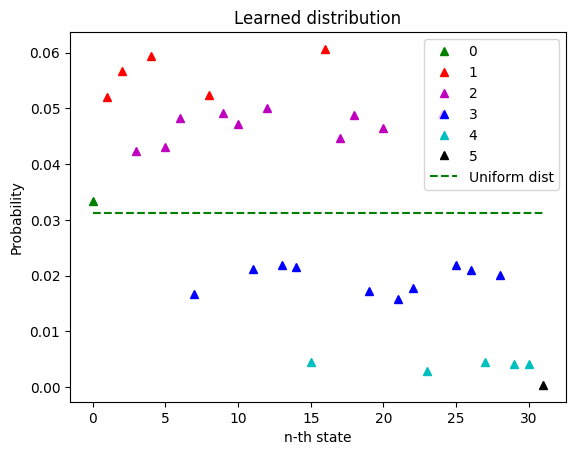

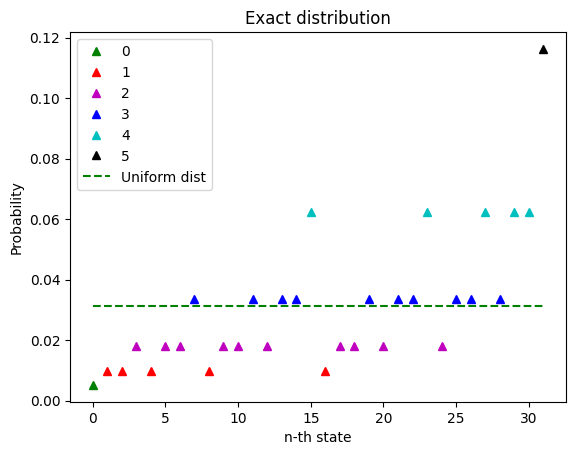


Results for W = 1's
##################################

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Partition function Z = 77161996288.0
Epoch 0: error is 6106.219446555111
Epoch 1: error is 5273.254171036318
Epoch 2: error is 4496.230646495946
Epoch 3: error is 3771.900128508124
Epoch 4: error is 3150.1064374932553
Epoch 5: error is 2619.1432271072044
Epoch 6: error is 2174.3011533306762
Epoch 7: error is 1799.3494004100394
Epoch 8: error is 1513.538714776168
Epoch 9: error is 1269.1000082324542
Epoch 10: error is 1075.8547347229337
Epoch 11: error is 924.8370285082757
Epoch 12: error is 799.5900181754893
Epoch 13: error is 700.2104392268717
Epoch 14: error is 623.5463498462427
Epoch 15: error is 557.1747799711248
Epoch 16: error is 506.8016213816447
Epoch 17: error is 459.15064447577794
Epoch 18: error is 418.36964936722427
Epoch 19: error is 394.3789152316969
Epoch 20: error is 365.1215892964862
Epoch 21: error is 345.48124185096435
Epoch 22: error is 325.9

Epoch 318: error is 165.88592710695903
Epoch 319: error is 165.72965245185708
Epoch 320: error is 165.77584526765202
Epoch 321: error is 165.862838039094
Epoch 322: error is 165.91973459184806
Epoch 323: error is 165.8632829423825
Epoch 324: error is 165.82128557201304
Epoch 325: error is 165.51624661506546
Epoch 326: error is 165.88158197546227
Epoch 327: error is 165.8103658181755
Epoch 328: error is 165.7688656009284
Epoch 329: error is 165.57369845590028
Epoch 330: error is 165.71059466412765
Epoch 331: error is 165.8008318742377
Epoch 332: error is 165.79257708876065
Epoch 333: error is 165.80703509678548
Epoch 334: error is 165.68937018948958
Epoch 335: error is 165.691614385968
Epoch 336: error is 165.85327267765015
Epoch 337: error is 165.71887736467335
Epoch 338: error is 165.7001499031451
Epoch 339: error is 165.92477111046566
Epoch 340: error is 165.74680149319906
Epoch 341: error is 165.80229402951716
Epoch 342: error is 165.7627555541798
Epoch 343: error is 165.94015466939

Epoch 553: error is 165.6887688838676
Epoch 554: error is 165.6584071313619
Epoch 555: error is 165.70856295526644
Epoch 556: error is 165.58215755475698
Epoch 557: error is 165.5781550602074
Epoch 558: error is 165.63193866346413
Epoch 559: error is 165.87268642522636
Epoch 560: error is 165.62244721094333
Epoch 561: error is 165.65013136059784
Epoch 562: error is 165.78782544929152
Epoch 563: error is 165.88585711836882
Epoch 564: error is 165.73239829011504
Epoch 565: error is 165.63150527901954
Epoch 566: error is 165.67061253513143
Epoch 567: error is 165.8776075091851
Epoch 568: error is 165.81650022762216
Epoch 569: error is 165.7226487456699
Epoch 570: error is 165.6440393169366
Epoch 571: error is 165.7574307801863
Epoch 572: error is 165.663912006776
Epoch 573: error is 165.62951393640742
Epoch 574: error is 165.72700082030062
Epoch 575: error is 165.67478760771223
Epoch 576: error is 166.02495049566488
Epoch 577: error is 165.67745047787088
Epoch 578: error is 165.6844319752

Epoch 845: error is 165.65619089364557
Epoch 846: error is 165.62544343151743
Epoch 847: error is 165.78739982541788
Epoch 848: error is 165.82796486057413
Epoch 849: error is 165.71501578204737
Epoch 850: error is 165.70840459562783
Epoch 851: error is 165.61028225757315
Epoch 852: error is 165.72899887304004
Epoch 853: error is 165.66534829148446
Epoch 854: error is 165.66750201672804
Epoch 855: error is 165.70716766300106
Epoch 856: error is 165.73644402429287
Epoch 857: error is 165.7110185782924
Epoch 858: error is 165.7256874703928
Epoch 859: error is 165.70233835315832
Epoch 860: error is 165.52548790499148
Epoch 861: error is 165.74261098165005
Epoch 862: error is 165.75335415690927
Epoch 863: error is 165.74385177772055
Epoch 864: error is 165.93073147200124
Epoch 865: error is 165.83417102973033
Epoch 866: error is 165.76371165288217
Epoch 867: error is 165.75685925926535
Epoch 868: error is 165.78186752037357
Epoch 869: error is 165.6981951594287
Epoch 870: error is 165.6481

Epoch 1108: error is 165.52349628997956
Epoch 1109: error is 165.67615081728832
Epoch 1110: error is 165.7956010983079
Epoch 1111: error is 165.77839749525947
Epoch 1112: error is 165.75651368887344
Epoch 1113: error is 165.61525009956532
Epoch 1114: error is 165.57780580848643
Epoch 1115: error is 165.74917927239798
Epoch 1116: error is 165.7180325559322
Epoch 1117: error is 165.64859120208754
Epoch 1118: error is 165.7161267924296
Epoch 1119: error is 165.8598090357451
Epoch 1120: error is 165.62262609925565
Epoch 1121: error is 165.83276116998076
Epoch 1122: error is 165.62668592100133
Epoch 1123: error is 165.59360880076835
Epoch 1124: error is 165.69027667497156
Epoch 1125: error is 165.76123210500884
Epoch 1126: error is 165.67994271328266
Epoch 1127: error is 165.70363301180075
Epoch 1128: error is 165.78160829722498
Epoch 1129: error is 165.72056107573388
Epoch 1130: error is 165.786462324811
Epoch 1131: error is 165.69839991656622
Epoch 1132: error is 165.80124320822563
Epoch 

Epoch 1423: error is 165.89439399838645
Epoch 1424: error is 165.604971318399
Epoch 1425: error is 165.7857544828627
Epoch 1426: error is 165.74690372437698
Epoch 1427: error is 165.77793446597073
Epoch 1428: error is 165.7253954943361
Epoch 1429: error is 165.76012268343683
Epoch 1430: error is 165.71855850961293
Epoch 1431: error is 165.7428981258
Epoch 1432: error is 165.84495361302743
Epoch 1433: error is 165.50910001596586
Epoch 1434: error is 165.69819057621908
Epoch 1435: error is 165.7531554529668
Epoch 1436: error is 165.60502706482717
Epoch 1437: error is 165.7458949425852
Epoch 1438: error is 165.64737213309309
Epoch 1439: error is 165.6579799083547
Epoch 1440: error is 165.59927213142151
Epoch 1441: error is 165.60108124960206
Epoch 1442: error is 165.81100991876409
Epoch 1443: error is 165.70403430985283
Epoch 1444: error is 165.83470660054746
Epoch 1445: error is 165.88563011644206
Epoch 1446: error is 165.66475285121828
Epoch 1447: error is 165.71407509458743
Epoch 1448:

Epoch 1633: error is 165.6822418679269
Epoch 1634: error is 165.82544778551747
Epoch 1635: error is 165.80565997268198
Epoch 1636: error is 165.64793794978172
Epoch 1637: error is 165.9422381821288
Epoch 1638: error is 165.81989993962034
Epoch 1639: error is 165.69884563195933
Epoch 1640: error is 165.61861655214045
Epoch 1641: error is 165.73143807729687
Epoch 1642: error is 165.83800121572426
Epoch 1643: error is 165.73657274673008
Epoch 1644: error is 165.82991327901811
Epoch 1645: error is 165.73614986276124
Epoch 1646: error is 165.6258517909347
Epoch 1647: error is 165.53705962922905
Epoch 1648: error is 165.9538602498221
Epoch 1649: error is 165.69910636590257
Epoch 1650: error is 165.73446439062468
Epoch 1651: error is 165.933881234072
Epoch 1652: error is 165.6882089444382
Epoch 1653: error is 165.82905717430577
Epoch 1654: error is 165.69327401544098
Epoch 1655: error is 165.58727534232975
Epoch 1656: error is 165.7325511447335
Epoch 1657: error is 165.90080094486214
Epoch 16

Epoch 1935: error is 165.71095380481637
Epoch 1936: error is 165.6970293071265
Epoch 1937: error is 165.47899238875954
Epoch 1938: error is 165.6224045431159
Epoch 1939: error is 165.75910909761797
Epoch 1940: error is 165.5834165251814
Epoch 1941: error is 165.76170566331115
Epoch 1942: error is 165.83006309207997
Epoch 1943: error is 165.58613754281816
Epoch 1944: error is 165.77613360299028
Epoch 1945: error is 165.55773445300787
Epoch 1946: error is 165.7516333862109
Epoch 1947: error is 165.5946475597208
Epoch 1948: error is 165.7314485778997
Epoch 1949: error is 165.53153260474676
Epoch 1950: error is 165.61089892216407
Epoch 1951: error is 165.7275884039288
Epoch 1952: error is 165.76892255587737
Epoch 1953: error is 165.7863882956606
Epoch 1954: error is 165.56614350025382
Epoch 1955: error is 165.86654377774562
Epoch 1956: error is 165.72247919060328
Epoch 1957: error is 165.76025316610787
Epoch 1958: error is 165.76562324953406
Epoch 1959: error is 165.78381365614172
Epoch 19

Epoch 2198: error is 165.68810941809124
Epoch 2199: error is 165.5908730815329
Epoch 2200: error is 165.64805767489068
Epoch 2201: error is 165.7040935644415
Epoch 2202: error is 165.6360206776833
Epoch 2203: error is 165.59565391953439
Epoch 2204: error is 165.66630825700034
Epoch 2205: error is 165.71582202502907
Epoch 2206: error is 165.6869170832959
Epoch 2207: error is 165.74852263927994
Epoch 2208: error is 165.61675804897234
Epoch 2209: error is 165.65869726791107
Epoch 2210: error is 165.77549713571995
Epoch 2211: error is 165.71803732295308
Epoch 2212: error is 165.54030045422368
Epoch 2213: error is 165.42183246312499
Epoch 2214: error is 165.63200758165908
Epoch 2215: error is 165.6528345241278
Epoch 2216: error is 165.79995219436483
Epoch 2217: error is 165.66704002101392
Epoch 2218: error is 165.7990769294642
Epoch 2219: error is 165.7448123212081
Epoch 2220: error is 165.57489572808595
Epoch 2221: error is 165.70725574638783
Epoch 2222: error is 165.87063508243097
Epoch 2

Epoch 2496: error is 165.5655327192593
Epoch 2497: error is 165.86602603131865
Epoch 2498: error is 165.86548059241034
Epoch 2499: error is 165.57152800364963
Epoch 2500: error is 165.7474797491133
Epoch 2501: error is 165.72618204384514
Epoch 2502: error is 165.8976714703225
Epoch 2503: error is 165.83406917790086
Epoch 2504: error is 165.78207159128542
Epoch 2505: error is 165.7014231386469
Epoch 2506: error is 165.62613421207752
Epoch 2507: error is 165.79960212772139
Epoch 2508: error is 165.61482273506837
Epoch 2509: error is 165.68444669699755
Epoch 2510: error is 165.72280006867211
Epoch 2511: error is 165.76566597829083
Epoch 2512: error is 165.64551002575283
Epoch 2513: error is 165.66263839482087
Epoch 2514: error is 165.62245288956262
Epoch 2515: error is 165.6146796068473
Epoch 2516: error is 165.5820157868367
Epoch 2517: error is 165.6474940786013
Epoch 2518: error is 165.40670409195798
Epoch 2519: error is 165.7296299636816
Epoch 2520: error is 165.6767807251407
Epoch 252

Epoch 2719: error is 165.70381170317916
Epoch 2720: error is 165.7693189524714
Epoch 2721: error is 165.5925599082808
Epoch 2722: error is 165.71582119602567
Epoch 2723: error is 165.72476687679074
Epoch 2724: error is 165.84799091634528
Epoch 2725: error is 165.7853470168759
Epoch 2726: error is 165.60260591870582
Epoch 2727: error is 165.79801558121252
Epoch 2728: error is 165.85097243421663
Epoch 2729: error is 165.59899165039883
Epoch 2730: error is 165.7192671225935
Epoch 2731: error is 165.60754472339224
Epoch 2732: error is 165.82166216929969
Epoch 2733: error is 165.79692823005615
Epoch 2734: error is 165.73785271295316
Epoch 2735: error is 165.70799590520252
Epoch 2736: error is 165.79584437176052
Epoch 2737: error is 165.45924471435654
Epoch 2738: error is 165.68698822728754
Epoch 2739: error is 165.68290223580513
Epoch 2740: error is 165.60446917453157
Epoch 2741: error is 165.70877000706457
Epoch 2742: error is 165.68340228385853
Epoch 2743: error is 165.75550845577396
Epoc

Epoch 2938: error is 165.63901889625498
Epoch 2939: error is 165.6960958912773
Epoch 2940: error is 165.751256059546
Epoch 2941: error is 165.67321065808437
Epoch 2942: error is 165.70302248340738
Epoch 2943: error is 165.7388835595837
Epoch 2944: error is 165.75621864510092
Epoch 2945: error is 165.68652219599372
Epoch 2946: error is 165.68632689933747
Epoch 2947: error is 165.80429004712872
Epoch 2948: error is 165.66494794750344
Epoch 2949: error is 165.76659251938938
Epoch 2950: error is 165.76093534554383
Epoch 2951: error is 165.802196611594
Epoch 2952: error is 165.79107253173459
Epoch 2953: error is 165.58577774918308
Epoch 2954: error is 165.71632991961303
Epoch 2955: error is 165.83607226257533
Epoch 2956: error is 165.8696739119138
Epoch 2957: error is 165.61581739145862
Epoch 2958: error is 165.90478426434942
Epoch 2959: error is 165.63618674666233
Epoch 2960: error is 165.35502294153068
Epoch 2961: error is 165.63047436277276
Epoch 2962: error is 165.6702180720864
Epoch 29

Epoch 3152: error is 165.82659936492942
Epoch 3153: error is 165.65282425074753
Epoch 3154: error is 165.60732304441964
Epoch 3155: error is 165.6167929674677
Epoch 3156: error is 165.69623910197882
Epoch 3157: error is 165.76509057719971
Epoch 3158: error is 165.64431195238308
Epoch 3159: error is 165.5686721591116
Epoch 3160: error is 165.78437853599726
Epoch 3161: error is 165.67283425421473
Epoch 3162: error is 165.74993185073126
Epoch 3163: error is 165.72906968424874
Epoch 3164: error is 165.74756393287478
Epoch 3165: error is 165.77759141816006
Epoch 3166: error is 165.52399159009812
Epoch 3167: error is 165.65048549319238
Epoch 3168: error is 165.6554763044338
Epoch 3169: error is 165.6843731914833
Epoch 3170: error is 165.63854816099453
Epoch 3171: error is 165.66621929754754
Epoch 3172: error is 165.67218713800887
Epoch 3173: error is 165.69789476205267
Epoch 3174: error is 165.48160706541483
Epoch 3175: error is 165.78737432515788
Epoch 3176: error is 165.7935697739115
Epoch

Epoch 3400: error is 165.89182438453753
Epoch 3401: error is 165.69074780747323
Epoch 3402: error is 165.88362214126028
Epoch 3403: error is 165.56149280749716
Epoch 3404: error is 165.771363901
Epoch 3405: error is 165.7913588194516
Epoch 3406: error is 165.83747814505384
Epoch 3407: error is 165.80980063673053
Epoch 3408: error is 165.67850550641623
Epoch 3409: error is 165.6226556305936
Epoch 3410: error is 165.67031223923792
Epoch 3411: error is 165.6615660743669
Epoch 3412: error is 165.73007773608612
Epoch 3413: error is 165.80173272424813
Epoch 3414: error is 165.71250956876
Epoch 3415: error is 165.68013052835337
Epoch 3416: error is 165.74129958709227
Epoch 3417: error is 165.83845268060645
Epoch 3418: error is 165.74047900050155
Epoch 3419: error is 165.59856458277403
Epoch 3420: error is 165.73771234331443
Epoch 3421: error is 165.58455456273694
Epoch 3422: error is 165.68335282130278
Epoch 3423: error is 165.70242132365433
Epoch 3424: error is 165.72746209824248
Epoch 3425:

Epoch 3702: error is 165.73608670484367
Epoch 3703: error is 165.63598799930136
Epoch 3704: error is 165.58310002757756
Epoch 3705: error is 165.76639307052523
Epoch 3706: error is 165.72086575941734
Epoch 3707: error is 165.731954773959
Epoch 3708: error is 165.5597923268257
Epoch 3709: error is 165.82387818324924
Epoch 3710: error is 165.6800020346809
Epoch 3711: error is 165.83180889625243
Epoch 3712: error is 165.782102702062
Epoch 3713: error is 165.47323104738734
Epoch 3714: error is 165.67326098544777
Epoch 3715: error is 165.8072185378401
Epoch 3716: error is 165.61763592685426
Epoch 3717: error is 165.62629859441995
Epoch 3718: error is 165.74964702433928
Epoch 3719: error is 165.67852698343688
Epoch 3720: error is 165.56085198193847
Epoch 3721: error is 165.87292764264618
Epoch 3722: error is 165.8841277698827
Epoch 3723: error is 165.55837478051558
Epoch 3724: error is 165.73894933433633
Epoch 3725: error is 165.5719570395559
Epoch 3726: error is 165.5519051194966
Epoch 3727

Epoch 3918: error is 165.66763429070744
Epoch 3919: error is 165.61767046350585
Epoch 3920: error is 165.79424472369251
Epoch 3921: error is 165.79326121354353
Epoch 3922: error is 165.6626630479269
Epoch 3923: error is 165.58225556629452
Epoch 3924: error is 165.65120124001805
Epoch 3925: error is 165.72177442617985
Epoch 3926: error is 165.81878368400646
Epoch 3927: error is 165.72762249794752
Epoch 3928: error is 165.63414311203468
Epoch 3929: error is 165.8155330343632
Epoch 3930: error is 165.7144324940151
Epoch 3931: error is 165.56720330379886
Epoch 3932: error is 165.69616487059136
Epoch 3933: error is 165.7551371321308
Epoch 3934: error is 165.4687890333427
Epoch 3935: error is 165.94741824121195
Epoch 3936: error is 165.73322228952256
Epoch 3937: error is 165.72586320650575
Epoch 3938: error is 165.670940380916
Epoch 3939: error is 165.75136979444707
Epoch 3940: error is 165.81078341176018
Epoch 3941: error is 165.7151137435334
Epoch 3942: error is 165.63629784803206
Epoch 39

Epoch 4140: error is 165.69838275038865
Epoch 4141: error is 165.61907441158962
Epoch 4142: error is 165.84609859364664
Epoch 4143: error is 165.699102849282
Epoch 4144: error is 165.79519664168126
Epoch 4145: error is 165.6339282519271
Epoch 4146: error is 165.70943877102
Epoch 4147: error is 165.6817279269709
Epoch 4148: error is 165.5623731762893
Epoch 4149: error is 165.5541973766165
Epoch 4150: error is 165.77319652612212
Epoch 4151: error is 165.751238822909
Epoch 4152: error is 165.78056047145557
Epoch 4153: error is 165.5784942444934
Epoch 4154: error is 165.7452151096548
Epoch 4155: error is 165.5578333700994
Epoch 4156: error is 165.67473502087316
Epoch 4157: error is 165.78288703569194
Epoch 4158: error is 165.71574781652453
Epoch 4159: error is 165.80232831511003
Epoch 4160: error is 165.61669392794147
Epoch 4161: error is 165.8042693098901
Epoch 4162: error is 165.87464239349399
Epoch 4163: error is 165.7402266723716
Epoch 4164: error is 165.73450228724397
Epoch 4165: erro

Epoch 4369: error is 165.7577352741573
Epoch 4370: error is 165.47775874101723
Epoch 4371: error is 165.6199444592406
Epoch 4372: error is 165.7591627114965
Epoch 4373: error is 165.8353445616394
Epoch 4374: error is 165.85091581753605
Epoch 4375: error is 165.49084169801614
Epoch 4376: error is 165.7963955802399
Epoch 4377: error is 165.67108525914858
Epoch 4378: error is 165.8618311317049
Epoch 4379: error is 165.5887156343743
Epoch 4380: error is 165.72396014460494
Epoch 4381: error is 165.69945443733133
Epoch 4382: error is 165.5698218651831
Epoch 4383: error is 165.82510593510568
Epoch 4384: error is 165.64414314453828
Epoch 4385: error is 165.75632659299632
Epoch 4386: error is 165.71170208290675
Epoch 4387: error is 165.67907332312106
Epoch 4388: error is 165.62852634821292
Epoch 4389: error is 165.7323991415523
Epoch 4390: error is 165.66491111560083
Epoch 4391: error is 165.75238896140894
Epoch 4392: error is 165.67712514250468
Epoch 4393: error is 165.90249940192055
Epoch 439

Epoch 4581: error is 165.91524163262253
Epoch 4582: error is 165.68186544695527
Epoch 4583: error is 165.616065738839
Epoch 4584: error is 165.88944170737096
Epoch 4585: error is 165.45152024761987
Epoch 4586: error is 165.75697885843843
Epoch 4587: error is 165.69522150032373
Epoch 4588: error is 165.83673643886007
Epoch 4589: error is 165.49145110201135
Epoch 4590: error is 165.80324890285175
Epoch 4591: error is 165.74118389615322
Epoch 4592: error is 165.7268717326473
Epoch 4593: error is 165.61457591347224
Epoch 4594: error is 165.82502338949325
Epoch 4595: error is 165.58169573419278
Epoch 4596: error is 165.67460827347853
Epoch 4597: error is 165.71489646520317
Epoch 4598: error is 165.71413417529126
Epoch 4599: error is 165.71958095834887
Epoch 4600: error is 165.8041749145841
Epoch 4601: error is 165.776037160553
Epoch 4602: error is 165.88784606788857
Epoch 4603: error is 165.52590555911948
Epoch 4604: error is 165.8417678847976
Epoch 4605: error is 165.59313113345624
Epoch 4

Epoch 4790: error is 165.70988013506906
Epoch 4791: error is 165.51737740949704
Epoch 4792: error is 165.66716652938527
Epoch 4793: error is 165.7961611983515
Epoch 4794: error is 165.55293987512496
Epoch 4795: error is 165.76439543195957
Epoch 4796: error is 165.4252418425468
Epoch 4797: error is 165.52008677499526
Epoch 4798: error is 165.50830596429856
Epoch 4799: error is 165.64437745129703
Epoch 4800: error is 165.79751668701493
Epoch 4801: error is 165.7892778671831
Epoch 4802: error is 165.78324125261227
Epoch 4803: error is 165.59451811195288
Epoch 4804: error is 165.70271459995664
Epoch 4805: error is 165.61263043632724
Epoch 4806: error is 165.59863614435596
Epoch 4807: error is 165.62643108634583
Epoch 4808: error is 165.7579598633074
Epoch 4809: error is 165.59431168804255
Epoch 4810: error is 165.6031962473883
Epoch 4811: error is 165.5532944921489
Epoch 4812: error is 165.6598173966287
Epoch 4813: error is 165.61740692506052
Epoch 4814: error is 165.7409473937402
Epoch 48

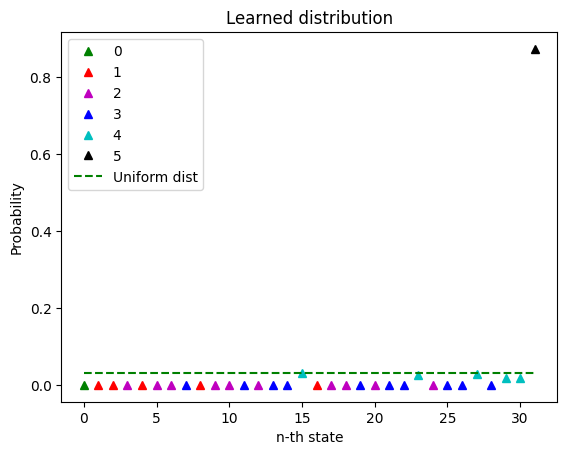

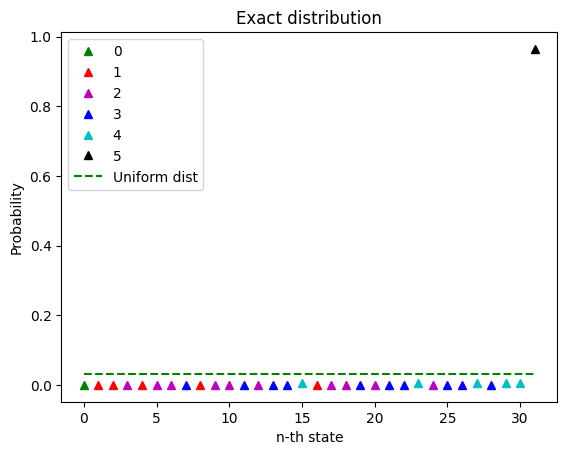


Results for W = 1's - identity
##################################

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Partition function Z = 588912000.0
Epoch 0: error is 6112.343214570839
Epoch 1: error is 5322.198370288623
Epoch 2: error is 4582.696834587097
Epoch 3: error is 3920.2179478635517
Epoch 4: error is 3327.373989820696
Epoch 5: error is 2818.876844009653
Epoch 6: error is 2400.683490001821
Epoch 7: error is 2059.0149551938616
Epoch 8: error is 1777.3523898612702
Epoch 9: error is 1534.8988224835568
Epoch 10: error is 1371.256272708667
Epoch 11: error is 1208.0198176578047
Epoch 12: error is 1096.0727653200372
Epoch 13: error is 1005.3193970158816
Epoch 14: error is 923.4255497889551
Epoch 15: error is 865.135501259784
Epoch 16: error is 805.1900843715362
Epoch 17: error is 770.405449842898
Epoch 18: error is 733.0975976157403
Epoch 19: error is 708.833138205597
Epoch 20: error is 675.9585604391618
Epoch 21: error is 660.598547931693
Epoch 22: error is 64

Epoch 254: error is 506.2249808644726
Epoch 255: error is 506.52470336273973
Epoch 256: error is 506.70793985443663
Epoch 257: error is 507.17206973958133
Epoch 258: error is 506.80781091737714
Epoch 259: error is 506.58762265538405
Epoch 260: error is 505.9529271343782
Epoch 261: error is 506.5081932323531
Epoch 262: error is 507.08996421492236
Epoch 263: error is 506.52440242853754
Epoch 264: error is 506.47215274177114
Epoch 265: error is 506.81570959239093
Epoch 266: error is 507.0940798338448
Epoch 267: error is 506.6115294174066
Epoch 268: error is 506.65127644090666
Epoch 269: error is 507.0680863924906
Epoch 270: error is 506.7974768549648
Epoch 271: error is 506.67674513387533
Epoch 272: error is 507.0006469949773
Epoch 273: error is 506.56455382484285
Epoch 274: error is 507.25947919902796
Epoch 275: error is 507.1803193612336
Epoch 276: error is 507.6425000804451
Epoch 277: error is 508.0887263153759
Epoch 278: error is 507.3558050229773
Epoch 279: error is 506.7281830566211

Epoch 549: error is 506.8511184256439
Epoch 550: error is 506.3348742413746
Epoch 551: error is 507.4697964740292
Epoch 552: error is 506.12906801067214
Epoch 553: error is 506.48409456316654
Epoch 554: error is 506.26881212353214
Epoch 555: error is 506.3610351635539
Epoch 556: error is 505.938698410882
Epoch 557: error is 505.8703294162516
Epoch 558: error is 506.08154508621845
Epoch 559: error is 506.08406465429334
Epoch 560: error is 507.02776936138406
Epoch 561: error is 506.15746546560945
Epoch 562: error is 506.14506031071664
Epoch 563: error is 506.30028585916494
Epoch 564: error is 506.5498808988889
Epoch 565: error is 506.4401137601933
Epoch 566: error is 506.30229251038554
Epoch 567: error is 506.02097678990947
Epoch 568: error is 507.4792331201103
Epoch 569: error is 506.5775772121976
Epoch 570: error is 507.07323121623085
Epoch 571: error is 506.8819187157348
Epoch 572: error is 506.3257687080396
Epoch 573: error is 507.09326784083316
Epoch 574: error is 507.02168051678245

Epoch 811: error is 506.3854685318681
Epoch 812: error is 507.07241002455646
Epoch 813: error is 506.43360681296906
Epoch 814: error is 507.22176312080944
Epoch 815: error is 506.99513789797265
Epoch 816: error is 507.71445023333456
Epoch 817: error is 506.7822126448813
Epoch 818: error is 506.3116622174265
Epoch 819: error is 507.01006709950457
Epoch 820: error is 506.3851871024531
Epoch 821: error is 505.47178105011324
Epoch 822: error is 506.59616233417614
Epoch 823: error is 506.8783976465373
Epoch 824: error is 506.56507998673595
Epoch 825: error is 506.5454044632579
Epoch 826: error is 506.1187068919271
Epoch 827: error is 507.1016342114175
Epoch 828: error is 506.78484094789576
Epoch 829: error is 506.91419483581984
Epoch 830: error is 506.62551346627197
Epoch 831: error is 506.22602355251036
Epoch 832: error is 506.9252652609338
Epoch 833: error is 506.3067607614916
Epoch 834: error is 506.6136026355353
Epoch 835: error is 506.8270749669791
Epoch 836: error is 507.1575111588954

Epoch 1036: error is 507.6616955560785
Epoch 1037: error is 507.2370170734008
Epoch 1038: error is 507.1365181333867
Epoch 1039: error is 506.2425483455073
Epoch 1040: error is 506.10243642250356
Epoch 1041: error is 506.58750333252743
Epoch 1042: error is 506.45510125797864
Epoch 1043: error is 506.19751982354387
Epoch 1044: error is 506.758883005715
Epoch 1045: error is 506.3694952978325
Epoch 1046: error is 507.1613509418792
Epoch 1047: error is 506.97979272660353
Epoch 1048: error is 506.34627966081644
Epoch 1049: error is 506.05745534138964
Epoch 1050: error is 507.63223997398387
Epoch 1051: error is 507.0505138986181
Epoch 1052: error is 505.67968609250124
Epoch 1053: error is 506.52804275646196
Epoch 1054: error is 506.5545784408506
Epoch 1055: error is 506.14568004302316
Epoch 1056: error is 506.22090500742803
Epoch 1057: error is 507.0406437730857
Epoch 1058: error is 505.9762276152735
Epoch 1059: error is 506.4918987428014
Epoch 1060: error is 505.71633489863746
Epoch 1061: e

Epoch 1258: error is 506.38051863274046
Epoch 1259: error is 505.9950494112475
Epoch 1260: error is 506.0577964022365
Epoch 1261: error is 506.0666486573071
Epoch 1262: error is 506.2773219164278
Epoch 1263: error is 506.5565719816906
Epoch 1264: error is 507.2898604230181
Epoch 1265: error is 506.83587750897937
Epoch 1266: error is 506.2834558418409
Epoch 1267: error is 506.8128567813236
Epoch 1268: error is 506.2838263092324
Epoch 1269: error is 506.8933868781094
Epoch 1270: error is 506.1714819106214
Epoch 1271: error is 506.5452837251636
Epoch 1272: error is 506.6842003785858
Epoch 1273: error is 506.94993448371963
Epoch 1274: error is 506.286818746732
Epoch 1275: error is 506.3439212587651
Epoch 1276: error is 506.46064048712395
Epoch 1277: error is 506.440711136121
Epoch 1278: error is 507.6182808406837
Epoch 1279: error is 507.0984571801782
Epoch 1280: error is 506.3166708130219
Epoch 1281: error is 506.634409242407
Epoch 1282: error is 506.63233440540796
Epoch 1283: error is 50

Epoch 1534: error is 507.1223149792388
Epoch 1535: error is 506.3730502555966
Epoch 1536: error is 505.8901224231821
Epoch 1537: error is 505.8569957364355
Epoch 1538: error is 506.85128746903246
Epoch 1539: error is 507.09345399184326
Epoch 1540: error is 506.29820055040904
Epoch 1541: error is 507.14661268562344
Epoch 1542: error is 506.2127707058353
Epoch 1543: error is 506.60222243801854
Epoch 1544: error is 506.7449381767678
Epoch 1545: error is 505.9879623471007
Epoch 1546: error is 506.7872358130612
Epoch 1547: error is 507.2531075473505
Epoch 1548: error is 506.9018832318479
Epoch 1549: error is 506.71142495113895
Epoch 1550: error is 506.51713447211694
Epoch 1551: error is 506.15571677573894
Epoch 1552: error is 506.7498666437684
Epoch 1553: error is 507.009153706391
Epoch 1554: error is 506.8960755125218
Epoch 1555: error is 506.4698970391928
Epoch 1556: error is 507.29333559947594
Epoch 1557: error is 507.25073936355307
Epoch 1558: error is 505.88568005968887
Epoch 1559: err

Epoch 1844: error is 507.0593172606999
Epoch 1845: error is 505.30083387617935
Epoch 1846: error is 506.4718626978867
Epoch 1847: error is 506.96340116201895
Epoch 1848: error is 506.4005214365773
Epoch 1849: error is 505.69736973168654
Epoch 1850: error is 506.0589586776043
Epoch 1851: error is 506.2596227439856
Epoch 1852: error is 507.42301478131276
Epoch 1853: error is 506.31689716259973
Epoch 1854: error is 505.9402522277953
Epoch 1855: error is 506.32288333792076
Epoch 1856: error is 507.5259522817921
Epoch 1857: error is 506.1539812950999
Epoch 1858: error is 505.46388670219653
Epoch 1859: error is 506.4190136441408
Epoch 1860: error is 506.71362770611734
Epoch 1861: error is 506.75313622896886
Epoch 1862: error is 506.14724796325225
Epoch 1863: error is 507.04947771370945
Epoch 1864: error is 506.6384509840399
Epoch 1865: error is 506.0695098122562
Epoch 1866: error is 506.8297989208809
Epoch 1867: error is 506.05775188088717
Epoch 1868: error is 505.9970379021951
Epoch 1869: e

Epoch 2075: error is 506.29345942339637
Epoch 2076: error is 505.6800136115436
Epoch 2077: error is 506.09567732596213
Epoch 2078: error is 505.83452282015276
Epoch 2079: error is 506.0997613932853
Epoch 2080: error is 505.9316753688527
Epoch 2081: error is 506.7447344928802
Epoch 2082: error is 506.5272402332318
Epoch 2083: error is 506.6807113060837
Epoch 2084: error is 507.75289140679956
Epoch 2085: error is 506.18960056025526
Epoch 2086: error is 506.282872902418
Epoch 2087: error is 505.6122352535089
Epoch 2088: error is 506.445505121011
Epoch 2089: error is 505.8573554203305
Epoch 2090: error is 507.0673925791914
Epoch 2091: error is 506.81587754602646
Epoch 2092: error is 506.1926907818359
Epoch 2093: error is 506.330840482833
Epoch 2094: error is 507.63343300047256
Epoch 2095: error is 506.7983122588551
Epoch 2096: error is 506.71854313808944
Epoch 2097: error is 506.52182581633934
Epoch 2098: error is 506.55480125020665
Epoch 2099: error is 506.67856005473215
Epoch 2100: error

Epoch 2320: error is 506.1073595942195
Epoch 2321: error is 506.2949016711139
Epoch 2322: error is 506.500571050674
Epoch 2323: error is 507.10472855458676
Epoch 2324: error is 506.6378664299441
Epoch 2325: error is 505.93404628749283
Epoch 2326: error is 506.56216402049654
Epoch 2327: error is 507.48985650721073
Epoch 2328: error is 506.6116307124561
Epoch 2329: error is 506.62978167573715
Epoch 2330: error is 506.41576133724664
Epoch 2331: error is 507.10653593290107
Epoch 2332: error is 506.56380076473636
Epoch 2333: error is 507.1593077737095
Epoch 2334: error is 506.3948888952186
Epoch 2335: error is 506.94158707046734
Epoch 2336: error is 505.84585189889566
Epoch 2337: error is 506.4491329736412
Epoch 2338: error is 506.56941193720445
Epoch 2339: error is 506.5737324348125
Epoch 2340: error is 505.8471222831368
Epoch 2341: error is 507.0165210937548
Epoch 2342: error is 506.7246916362653
Epoch 2343: error is 506.18661849985256
Epoch 2344: error is 506.5537654392398
Epoch 2345: er

Epoch 2543: error is 506.70123837904225
Epoch 2544: error is 505.810418062316
Epoch 2545: error is 506.5374200445292
Epoch 2546: error is 507.2571737555866
Epoch 2547: error is 505.88800732139055
Epoch 2548: error is 507.23211332733337
Epoch 2549: error is 506.4715706593056
Epoch 2550: error is 506.4539268444822
Epoch 2551: error is 505.7929140881111
Epoch 2552: error is 505.8492117163589
Epoch 2553: error is 505.41265575901696
Epoch 2554: error is 506.5556456077215
Epoch 2555: error is 506.42346535912327
Epoch 2556: error is 506.1615742128773
Epoch 2557: error is 506.71584360089105
Epoch 2558: error is 506.78945922253774
Epoch 2559: error is 506.10334589104684
Epoch 2560: error is 506.897730401484
Epoch 2561: error is 506.81596048695724
Epoch 2562: error is 506.5133291706079
Epoch 2563: error is 505.9091075137249
Epoch 2564: error is 506.614773071102
Epoch 2565: error is 506.84542324548795
Epoch 2566: error is 506.30815673864873
Epoch 2567: error is 506.67622205720824
Epoch 2568: erro

Epoch 2828: error is 505.3490969109938
Epoch 2829: error is 506.47123861413706
Epoch 2830: error is 506.0849381481112
Epoch 2831: error is 505.63612664705005
Epoch 2832: error is 507.1223114038468
Epoch 2833: error is 507.7496585296109
Epoch 2834: error is 505.3978532245789
Epoch 2835: error is 506.7830580656372
Epoch 2836: error is 506.53971901717006
Epoch 2837: error is 506.33889160289624
Epoch 2838: error is 506.7333972302712
Epoch 2839: error is 506.9122817650883
Epoch 2840: error is 505.66651191759036
Epoch 2841: error is 506.5102544017394
Epoch 2842: error is 507.4058765263818
Epoch 2843: error is 507.0747091293778
Epoch 2844: error is 506.5496378152024
Epoch 2845: error is 506.8820797774596
Epoch 2846: error is 505.75467883429343
Epoch 2847: error is 505.95558712361594
Epoch 2848: error is 505.8752854399788
Epoch 2849: error is 506.99826370839446
Epoch 2850: error is 506.2816787371322
Epoch 2851: error is 506.9838891895552
Epoch 2852: error is 504.7176109535876
Epoch 2853: error

Epoch 3038: error is 506.1333828950045
Epoch 3039: error is 506.41994213685825
Epoch 3040: error is 506.71975652631113
Epoch 3041: error is 506.3782557946032
Epoch 3042: error is 506.63206414065337
Epoch 3043: error is 506.3831349070859
Epoch 3044: error is 506.94029351265743
Epoch 3045: error is 506.21301480316833
Epoch 3046: error is 506.1407543263671
Epoch 3047: error is 506.54571109086146
Epoch 3048: error is 506.7472509912403
Epoch 3049: error is 506.7605327612125
Epoch 3050: error is 506.7707669699463
Epoch 3051: error is 506.0569458366982
Epoch 3052: error is 507.040411072653
Epoch 3053: error is 505.9848314402154
Epoch 3054: error is 507.0636359094839
Epoch 3055: error is 505.93164699468775
Epoch 3056: error is 506.024969534986
Epoch 3057: error is 506.9103209123934
Epoch 3058: error is 505.889848887875
Epoch 3059: error is 506.47988594487356
Epoch 3060: error is 506.3894932658949
Epoch 3061: error is 506.3264095219741
Epoch 3062: error is 506.7646113293199
Epoch 3063: error is

Epoch 3319: error is 506.01561730551316
Epoch 3320: error is 505.85144644324856
Epoch 3321: error is 505.9306458729641
Epoch 3322: error is 506.3591428403541
Epoch 3323: error is 505.85891075709094
Epoch 3324: error is 506.44816531299415
Epoch 3325: error is 507.07385318933245
Epoch 3326: error is 505.8584104414632
Epoch 3327: error is 506.6478695215097
Epoch 3328: error is 506.5540906373852
Epoch 3329: error is 506.4716493008318
Epoch 3330: error is 505.2886625343124
Epoch 3331: error is 506.96773231986685
Epoch 3332: error is 505.6825728610919
Epoch 3333: error is 505.3909651909015
Epoch 3334: error is 506.16923205901935
Epoch 3335: error is 506.2461708499402
Epoch 3336: error is 505.89797982500033
Epoch 3337: error is 504.88595044293794
Epoch 3338: error is 505.0115540654748
Epoch 3339: error is 507.6774791869923
Epoch 3340: error is 506.0536258981547
Epoch 3341: error is 505.4163067793596
Epoch 3342: error is 506.20465321619605
Epoch 3343: error is 507.01271072632585
Epoch 3344: er

Epoch 3532: error is 505.51276066994785
Epoch 3533: error is 506.1632281451821
Epoch 3534: error is 506.25922039735457
Epoch 3535: error is 505.9205597518053
Epoch 3536: error is 505.8641368421188
Epoch 3537: error is 506.2813600392259
Epoch 3538: error is 507.34256034159904
Epoch 3539: error is 506.57929751339645
Epoch 3540: error is 505.8404191486755
Epoch 3541: error is 506.10171418169045
Epoch 3542: error is 506.52172510105834
Epoch 3543: error is 506.2866334014649
Epoch 3544: error is 505.5062400763587
Epoch 3545: error is 506.08888371230546
Epoch 3546: error is 506.7508122536753
Epoch 3547: error is 506.6276946714544
Epoch 3548: error is 506.194683726188
Epoch 3549: error is 506.3603612664665
Epoch 3550: error is 506.1472721696896
Epoch 3551: error is 506.0486537858635
Epoch 3552: error is 507.0209808533608
Epoch 3553: error is 506.21173013505114
Epoch 3554: error is 506.8578882708375
Epoch 3555: error is 506.1737189502729
Epoch 3556: error is 506.6443214064136
Epoch 3557: error 

Epoch 3767: error is 505.7060699896955
Epoch 3768: error is 507.33613299439287
Epoch 3769: error is 506.2427929810161
Epoch 3770: error is 506.1823176800701
Epoch 3771: error is 505.88727916704914
Epoch 3772: error is 505.8954939227197
Epoch 3773: error is 505.6702382271801
Epoch 3774: error is 506.1513376391018
Epoch 3775: error is 506.4863847322172
Epoch 3776: error is 506.8909508742539
Epoch 3777: error is 506.7158716570362
Epoch 3778: error is 506.1048898182653
Epoch 3779: error is 506.41428729857444
Epoch 3780: error is 507.04655483675754
Epoch 3781: error is 507.06649726470573
Epoch 3782: error is 504.9384565621705
Epoch 3783: error is 506.46980805637793
Epoch 3784: error is 505.9117326957107
Epoch 3785: error is 506.03726801173957
Epoch 3786: error is 505.9879167673298
Epoch 3787: error is 506.4511145299773
Epoch 3788: error is 506.30557982553125
Epoch 3789: error is 505.70724884797716
Epoch 3790: error is 506.37424987627526
Epoch 3791: error is 505.4958656165155
Epoch 3792: err

Epoch 4014: error is 506.56251134402277
Epoch 4015: error is 506.8068941981375
Epoch 4016: error is 505.81186567674473
Epoch 4017: error is 506.0925008231144
Epoch 4018: error is 505.6035022513704
Epoch 4019: error is 505.2556268055238
Epoch 4020: error is 506.4237925606041
Epoch 4021: error is 506.1781786906561
Epoch 4022: error is 506.546450680349
Epoch 4023: error is 506.5408794235475
Epoch 4024: error is 505.4139007007592
Epoch 4025: error is 505.4685810795845
Epoch 4026: error is 506.6968901387482
Epoch 4027: error is 506.0458010410656
Epoch 4028: error is 507.8797660413875
Epoch 4029: error is 506.3445516208533
Epoch 4030: error is 506.6925211073728
Epoch 4031: error is 506.45693821898703
Epoch 4032: error is 506.0364679667168
Epoch 4033: error is 506.01263006574436
Epoch 4034: error is 506.18707262911926
Epoch 4035: error is 505.9147416244197
Epoch 4036: error is 506.3826100481982
Epoch 4037: error is 506.225831473402
Epoch 4038: error is 507.2225178138778
Epoch 4039: error is 5

Epoch 4231: error is 505.3627659457479
Epoch 4232: error is 507.0983184890949
Epoch 4233: error is 505.6235428980401
Epoch 4234: error is 506.1381029266728
Epoch 4235: error is 505.9790336363602
Epoch 4236: error is 507.00980542414527
Epoch 4237: error is 507.09373249435237
Epoch 4238: error is 506.3154633517568
Epoch 4239: error is 505.79908824229113
Epoch 4240: error is 506.3212613806732
Epoch 4241: error is 506.9493045951741
Epoch 4242: error is 505.8469003118564
Epoch 4243: error is 505.2684596159454
Epoch 4244: error is 505.90131904926784
Epoch 4245: error is 505.9055611814299
Epoch 4246: error is 506.0952349838742
Epoch 4247: error is 506.61962312484377
Epoch 4248: error is 505.5158243279159
Epoch 4249: error is 505.76855754443164
Epoch 4250: error is 505.92008743077963
Epoch 4251: error is 506.5999815784399
Epoch 4252: error is 506.66726073939964
Epoch 4253: error is 505.5771579724011
Epoch 4254: error is 505.93063426264337
Epoch 4255: error is 505.73777818002554
Epoch 4256: err

Epoch 4443: error is 504.6027883153658
Epoch 4444: error is 505.3207055690982
Epoch 4445: error is 505.9193363267309
Epoch 4446: error is 506.47503710269945
Epoch 4447: error is 504.87753656186976
Epoch 4448: error is 505.96562737321455
Epoch 4449: error is 506.21986868710826
Epoch 4450: error is 505.5844724276883
Epoch 4451: error is 506.4317918757331
Epoch 4452: error is 505.93337521719286
Epoch 4453: error is 505.82723330491496
Epoch 4454: error is 506.55040017113845
Epoch 4455: error is 505.0246959313562
Epoch 4456: error is 506.35331761225933
Epoch 4457: error is 506.2064118558213
Epoch 4458: error is 506.79054695010063
Epoch 4459: error is 505.67510188970914
Epoch 4460: error is 506.44770743493007
Epoch 4461: error is 506.2157986327888
Epoch 4462: error is 506.255337076896
Epoch 4463: error is 505.8414003391156
Epoch 4464: error is 505.95968230957556
Epoch 4465: error is 506.41280793115436
Epoch 4466: error is 504.77878640379254
Epoch 4467: error is 505.8169955241045
Epoch 4468: 

Epoch 4687: error is 505.71400445083395
Epoch 4688: error is 505.5669744338886
Epoch 4689: error is 505.60297349255495
Epoch 4690: error is 506.1419279306115
Epoch 4691: error is 506.54040515087144
Epoch 4692: error is 506.1470382970206
Epoch 4693: error is 505.90513188626005
Epoch 4694: error is 506.1763349103991
Epoch 4695: error is 506.226185222172
Epoch 4696: error is 506.1332992135159
Epoch 4697: error is 506.5556231238203
Epoch 4698: error is 506.89447393757763
Epoch 4699: error is 505.5326444394725
Epoch 4700: error is 505.82429941278247
Epoch 4701: error is 505.6322721076373
Epoch 4702: error is 506.6419834360676
Epoch 4703: error is 505.64987252739957
Epoch 4704: error is 507.06749563862826
Epoch 4705: error is 506.7330974790225
Epoch 4706: error is 506.14148362247306
Epoch 4707: error is 506.01522998503174
Epoch 4708: error is 506.46424371602836
Epoch 4709: error is 505.24013874010024
Epoch 4710: error is 505.700271157004
Epoch 4711: error is 505.46024249395293
Epoch 4712: er

Epoch 4931: error is 505.8476806503325
Epoch 4932: error is 505.29207053716596
Epoch 4933: error is 505.7504777042101
Epoch 4934: error is 505.7075643024307
Epoch 4935: error is 504.9529129220406
Epoch 4936: error is 505.69078748973993
Epoch 4937: error is 505.51859930196844
Epoch 4938: error is 505.31671822977466
Epoch 4939: error is 506.3693884809908
Epoch 4940: error is 505.83627427119745
Epoch 4941: error is 505.85661471208033
Epoch 4942: error is 505.90520296433004
Epoch 4943: error is 506.8470121284475
Epoch 4944: error is 506.29119858668133
Epoch 4945: error is 505.4113505117125
Epoch 4946: error is 505.6648325476481
Epoch 4947: error is 505.20659815642983
Epoch 4948: error is 506.28138426087503
Epoch 4949: error is 506.44825404129483
Epoch 4950: error is 504.6486164179805
Epoch 4951: error is 506.8028835321438
Epoch 4952: error is 506.2674880685079
Epoch 4953: error is 505.7315545715809
Epoch 4954: error is 506.351675967471
Epoch 4955: error is 506.24531017420406
Epoch 4956: er

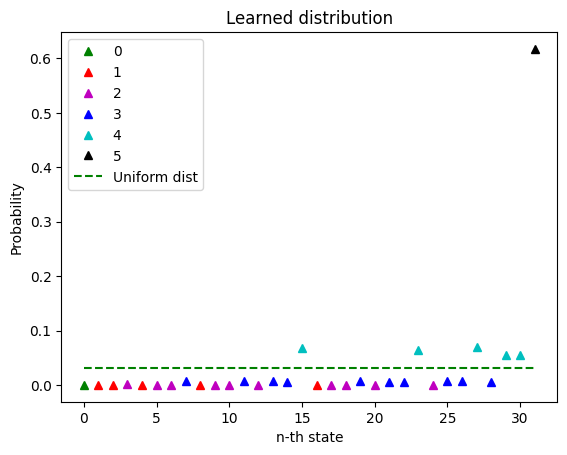

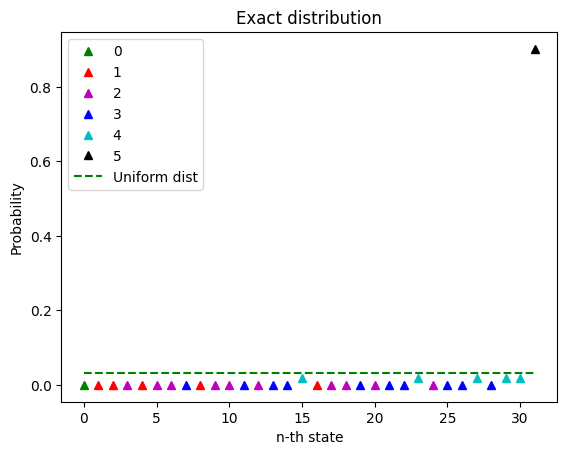


Results for W = Diagonal ones of size 3
##################################

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Partition function Z = 1124639.0
Epoch 0: error is 6135.916283561379
Epoch 1: error is 5564.9925667993875
Epoch 2: error is 5042.891773955838
Epoch 3: error is 4596.596640256772
Epoch 4: error is 4188.284290109484
Epoch 5: error is 3837.0971407857496
Epoch 6: error is 3535.6383655896107
Epoch 7: error is 3299.776662263469
Epoch 8: error is 3095.3179223958277
Epoch 9: error is 2937.1218891941626
Epoch 10: error is 2802.8442825256298
Epoch 11: error is 2708.2879228675743
Epoch 12: error is 2606.9197604360947
Epoch 13: error is 2540.558427537054
Epoch 14: error is 2474.1910906127496
Epoch 15: error is 2428.602353066738
Epoch 16: error is 2386.086927278725
Epoch 17: error is 2363.839077609386
Epoch 18: error is 2335.5542755537867
Epoch 19: error is 2321.1036751707156
Epoch 20: error is 2305.674781646145
Epoch 21: error is 2285.3637549248874
Epoch

Epoch 222: error is 2203.1887999389874
Epoch 223: error is 2203.358194215712
Epoch 224: error is 2204.5141233628533
Epoch 225: error is 2202.1120059135014
Epoch 226: error is 2204.9347876796805
Epoch 227: error is 2206.7701781221836
Epoch 228: error is 2205.9529319424137
Epoch 229: error is 2198.4271011056153
Epoch 230: error is 2201.5269029156893
Epoch 231: error is 2201.106656913734
Epoch 232: error is 2203.6018943190275
Epoch 233: error is 2203.24707674045
Epoch 234: error is 2212.649043023278
Epoch 235: error is 2206.550646301115
Epoch 236: error is 2201.6542980612794
Epoch 237: error is 2204.068536682482
Epoch 238: error is 2200.132617841876
Epoch 239: error is 2206.479612563674
Epoch 240: error is 2203.965687632957
Epoch 241: error is 2207.570317898819
Epoch 242: error is 2205.869058959846
Epoch 243: error is 2202.53453003491
Epoch 244: error is 2202.0683629532596
Epoch 245: error is 2203.0001798679195
Epoch 246: error is 2201.5189437123445
Epoch 247: error is 2202.899253279774
E

Epoch 460: error is 2201.15505217221
Epoch 461: error is 2205.828432150363
Epoch 462: error is 2205.4669522164836
Epoch 463: error is 2200.445692725256
Epoch 464: error is 2203.676845244542
Epoch 465: error is 2200.2887868759663
Epoch 466: error is 2203.791443516913
Epoch 467: error is 2201.099565734895
Epoch 468: error is 2205.8707233601904
Epoch 469: error is 2207.8367721995733
Epoch 470: error is 2204.348047256726
Epoch 471: error is 2201.152325114474
Epoch 472: error is 2203.887146061108
Epoch 473: error is 2204.196366920601
Epoch 474: error is 2205.172050418333
Epoch 475: error is 2204.3595894182477
Epoch 476: error is 2204.424018132666
Epoch 477: error is 2201.310462204233
Epoch 478: error is 2202.560286410357
Epoch 479: error is 2204.0282001469554
Epoch 480: error is 2210.41038980798
Epoch 481: error is 2207.8411683014383
Epoch 482: error is 2198.8401752500517
Epoch 483: error is 2202.0319296580938
Epoch 484: error is 2202.1229193356885
Epoch 485: error is 2205.6694243805205
Epo

Epoch 702: error is 2200.9788117581493
Epoch 703: error is 2197.0050160398214
Epoch 704: error is 2200.080212022951
Epoch 705: error is 2206.853361181037
Epoch 706: error is 2198.671455930608
Epoch 707: error is 2204.9416264560577
Epoch 708: error is 2199.5077487622384
Epoch 709: error is 2206.943903377175
Epoch 710: error is 2200.2496972832682
Epoch 711: error is 2203.074152934208
Epoch 712: error is 2203.7374234908175
Epoch 713: error is 2201.088688675069
Epoch 714: error is 2199.883105452023
Epoch 715: error is 2205.198476531753
Epoch 716: error is 2203.6715092219397
Epoch 717: error is 2201.5873863115635
Epoch 718: error is 2197.997713716332
Epoch 719: error is 2203.0543249353004
Epoch 720: error is 2201.963178448205
Epoch 721: error is 2205.444079808889
Epoch 722: error is 2198.149049928655
Epoch 723: error is 2207.519012211408
Epoch 724: error is 2204.477975935913
Epoch 725: error is 2204.189402880109
Epoch 726: error is 2203.7029373174782
Epoch 727: error is 2197.013488653655
Ep

Epoch 941: error is 2200.045849827783
Epoch 942: error is 2196.651371825911
Epoch 943: error is 2192.898081076061
Epoch 944: error is 2191.584905237151
Epoch 945: error is 2197.8767721668037
Epoch 946: error is 2196.8398086697043
Epoch 947: error is 2196.0151843536178
Epoch 948: error is 2189.463411419128
Epoch 949: error is 2193.707398954593
Epoch 950: error is 2193.169768203471
Epoch 951: error is 2196.1072784145676
Epoch 952: error is 2200.156664713987
Epoch 953: error is 2196.465328409753
Epoch 954: error is 2194.3128561771573
Epoch 955: error is 2201.817751713503
Epoch 956: error is 2197.349309528592
Epoch 957: error is 2193.667508042608
Epoch 958: error is 2193.944701560914
Epoch 959: error is 2194.309344368025
Epoch 960: error is 2188.2180536073242
Epoch 961: error is 2193.6800993274414
Epoch 962: error is 2192.654822950767
Epoch 963: error is 2189.069048482486
Epoch 964: error is 2196.6942566615357
Epoch 965: error is 2199.0606390964604
Epoch 966: error is 2196.5078484048454
Ep

Epoch 1183: error is 2178.91573774858
Epoch 1184: error is 2178.7203589567766
Epoch 1185: error is 2175.1511719841
Epoch 1186: error is 2184.2787370677684
Epoch 1187: error is 2184.200911082471
Epoch 1188: error is 2174.4302050929987
Epoch 1189: error is 2172.6197524106274
Epoch 1190: error is 2181.2185491024866
Epoch 1191: error is 2186.580548654539
Epoch 1192: error is 2176.6307509897406
Epoch 1193: error is 2181.7235407508792
Epoch 1194: error is 2174.407778861317
Epoch 1195: error is 2183.6264107534503
Epoch 1196: error is 2186.952729708507
Epoch 1197: error is 2175.364289420364
Epoch 1198: error is 2174.937421131328
Epoch 1199: error is 2172.772720854682
Epoch 1200: error is 2179.0107587929797
Epoch 1201: error is 2180.389415078422
Epoch 1202: error is 2173.6965837939842
Epoch 1203: error is 2171.0717470884415
Epoch 1204: error is 2174.9822381579165
Epoch 1205: error is 2183.6372779157628
Epoch 1206: error is 2174.397092690594
Epoch 1207: error is 2163.171147066917
Epoch 1208: err

Epoch 1425: error is 2124.9509584056686
Epoch 1426: error is 2130.3689212185877
Epoch 1427: error is 2133.855102314094
Epoch 1428: error is 2136.7402668407576
Epoch 1429: error is 2136.01575178894
Epoch 1430: error is 2134.259059752657
Epoch 1431: error is 2130.1521568848384
Epoch 1432: error is 2131.6526175160225
Epoch 1433: error is 2126.9665174982542
Epoch 1434: error is 2135.2681172344724
Epoch 1435: error is 2135.1997543561424
Epoch 1436: error is 2131.715538092045
Epoch 1437: error is 2123.81494037211
Epoch 1438: error is 2124.579923354522
Epoch 1439: error is 2124.686749640238
Epoch 1440: error is 2132.208561158312
Epoch 1441: error is 2126.9903052512905
Epoch 1442: error is 2129.505664124
Epoch 1443: error is 2122.4569557782156
Epoch 1444: error is 2140.3883281624476
Epoch 1445: error is 2126.358170349249
Epoch 1446: error is 2136.0547481376043
Epoch 1447: error is 2131.6809013176717
Epoch 1448: error is 2131.05708201797
Epoch 1449: error is 2117.28451953717
Epoch 1450: error i

Epoch 1662: error is 2043.669679469011
Epoch 1663: error is 2035.9010383132909
Epoch 1664: error is 2017.3800362618745
Epoch 1665: error is 2029.3719695515933
Epoch 1666: error is 2013.6214016036133
Epoch 1667: error is 2004.9718261571838
Epoch 1668: error is 2005.1854831869832
Epoch 1669: error is 2022.4109430690685
Epoch 1670: error is 2010.5980044028784
Epoch 1671: error is 2023.445266474449
Epoch 1672: error is 2017.322717001683
Epoch 1673: error is 2017.9590930642535
Epoch 1674: error is 2004.245522900755
Epoch 1675: error is 2003.3914570206011
Epoch 1676: error is 2005.2045677175076
Epoch 1677: error is 2010.1293664345917
Epoch 1678: error is 2020.330093792687
Epoch 1679: error is 2030.2885322185953
Epoch 1680: error is 2021.06805536937
Epoch 1681: error is 2004.3034747553927
Epoch 1682: error is 2004.183857323068
Epoch 1683: error is 2016.7333107871739
Epoch 1684: error is 2020.918992777527
Epoch 1685: error is 2021.2012154762765
Epoch 1686: error is 2019.7181902233006
Epoch 168

Epoch 1954: error is 1847.9147425107926
Epoch 1955: error is 1809.929343706444
Epoch 1956: error is 1799.6469793150209
Epoch 1957: error is 1807.265722558433
Epoch 1958: error is 1812.9966202495818
Epoch 1959: error is 1820.455890991343
Epoch 1960: error is 1790.8749733267869
Epoch 1961: error is 1805.159017362167
Epoch 1962: error is 1796.0045728226382
Epoch 1963: error is 1791.2592230359046
Epoch 1964: error is 1820.2682154923496
Epoch 1965: error is 1791.5732567787866
Epoch 1966: error is 1788.521040133182
Epoch 1967: error is 1802.9248577638673
Epoch 1968: error is 1814.992819917209
Epoch 1969: error is 1812.8197914505665
Epoch 1970: error is 1791.2517937178536
Epoch 1971: error is 1808.3963887911355
Epoch 1972: error is 1798.3634489538367
Epoch 1973: error is 1796.002428425656
Epoch 1974: error is 1789.0875159511181
Epoch 1975: error is 1782.401035432772
Epoch 1976: error is 1792.6057910505883
Epoch 1977: error is 1779.811439175096
Epoch 1978: error is 1799.5949171566633
Epoch 197

Epoch 2263: error is 1567.4396448020757
Epoch 2264: error is 1584.9190723595316
Epoch 2265: error is 1572.5786751900696
Epoch 2266: error is 1558.3878648013053
Epoch 2267: error is 1576.9489450455571
Epoch 2268: error is 1563.2851532421225
Epoch 2269: error is 1554.2456157560955
Epoch 2270: error is 1567.5400108458077
Epoch 2271: error is 1535.9991443566528
Epoch 2272: error is 1580.2202694448333
Epoch 2273: error is 1599.316082913874
Epoch 2274: error is 1582.9310879824511
Epoch 2275: error is 1596.0668887320167
Epoch 2276: error is 1547.1314739060585
Epoch 2277: error is 1578.5720727521275
Epoch 2278: error is 1556.126911656307
Epoch 2279: error is 1556.9086684936524
Epoch 2280: error is 1550.3251493808134
Epoch 2281: error is 1561.65190022472
Epoch 2282: error is 1578.8659515570214
Epoch 2283: error is 1569.7325640470774
Epoch 2284: error is 1562.3620743512636
Epoch 2285: error is 1540.0577199344073
Epoch 2286: error is 1563.7174093697613
Epoch 2287: error is 1524.8272218670286
Epoc

Epoch 2506: error is 1410.5030690958474
Epoch 2507: error is 1415.7733551921908
Epoch 2508: error is 1415.1513344140435
Epoch 2509: error is 1416.3127724240308
Epoch 2510: error is 1399.25606035958
Epoch 2511: error is 1383.1496717116997
Epoch 2512: error is 1391.866402467451
Epoch 2513: error is 1397.4009320451494
Epoch 2514: error is 1397.9199817893632
Epoch 2515: error is 1413.6564888592911
Epoch 2516: error is 1391.3672910026899
Epoch 2517: error is 1399.2660874866672
Epoch 2518: error is 1397.4554874694873
Epoch 2519: error is 1414.5498772470944
Epoch 2520: error is 1395.928578046094
Epoch 2521: error is 1414.8947969943688
Epoch 2522: error is 1402.999386787938
Epoch 2523: error is 1439.3176155838676
Epoch 2524: error is 1402.9156877264347
Epoch 2525: error is 1393.2408491563433
Epoch 2526: error is 1400.862284350105
Epoch 2527: error is 1400.3433047740878
Epoch 2528: error is 1405.2638239201888
Epoch 2529: error is 1410.0273876905312
Epoch 2530: error is 1391.9732074692831
Epoch 

Epoch 2743: error is 1294.341710379319
Epoch 2744: error is 1302.6094075848473
Epoch 2745: error is 1292.1664807148504
Epoch 2746: error is 1313.246789349917
Epoch 2747: error is 1290.7174594121561
Epoch 2748: error is 1312.3021086574804
Epoch 2749: error is 1307.1907070670436
Epoch 2750: error is 1284.3958499672563
Epoch 2751: error is 1302.3542409273966
Epoch 2752: error is 1313.4071602486545
Epoch 2753: error is 1289.4718716376824
Epoch 2754: error is 1315.7635092136238
Epoch 2755: error is 1290.3714944249073
Epoch 2756: error is 1325.9554028277719
Epoch 2757: error is 1296.9761042995328
Epoch 2758: error is 1282.9101291456068
Epoch 2759: error is 1305.721672945225
Epoch 2760: error is 1284.5281327496004
Epoch 2761: error is 1295.5658752178133
Epoch 2762: error is 1297.665292652659
Epoch 2763: error is 1288.6996062995704
Epoch 2764: error is 1329.8475715943814
Epoch 2765: error is 1292.5841554792182
Epoch 2766: error is 1305.1845063456287
Epoch 2767: error is 1298.432886553383
Epoch

Epoch 2958: error is 1197.863330425262
Epoch 2959: error is 1219.0910507863719
Epoch 2960: error is 1219.9461267498586
Epoch 2961: error is 1227.134073101517
Epoch 2962: error is 1214.2143851253124
Epoch 2963: error is 1228.2277100784272
Epoch 2964: error is 1221.2854518726124
Epoch 2965: error is 1209.0168381836581
Epoch 2966: error is 1229.9938625973298
Epoch 2967: error is 1231.2987493181136
Epoch 2968: error is 1215.5594906402682
Epoch 2969: error is 1223.674411837109
Epoch 2970: error is 1212.6867206470884
Epoch 2971: error is 1200.0383792505058
Epoch 2972: error is 1231.47387144701
Epoch 2973: error is 1215.0742105138213
Epoch 2974: error is 1233.3264932969723
Epoch 2975: error is 1208.3949958704848
Epoch 2976: error is 1213.2847120481713
Epoch 2977: error is 1218.4169487464517
Epoch 2978: error is 1215.8287422643782
Epoch 2979: error is 1218.7246603506567
Epoch 2980: error is 1236.650441601821
Epoch 2981: error is 1223.8113152375747
Epoch 2982: error is 1233.269282204289
Epoch 2

Epoch 3193: error is 1180.1571550247766
Epoch 3194: error is 1140.6040845279344
Epoch 3195: error is 1157.1045475121605
Epoch 3196: error is 1149.4629049489365
Epoch 3197: error is 1175.0955886172437
Epoch 3198: error is 1170.719239186879
Epoch 3199: error is 1172.4248866179562
Epoch 3200: error is 1174.6195929930714
Epoch 3201: error is 1159.583772713973
Epoch 3202: error is 1142.8495493788673
Epoch 3203: error is 1133.799583471751
Epoch 3204: error is 1147.8543930193725
Epoch 3205: error is 1138.4353015882195
Epoch 3206: error is 1176.245518106408
Epoch 3207: error is 1152.6306821379255
Epoch 3208: error is 1155.3885741539214
Epoch 3209: error is 1151.9007842845617
Epoch 3210: error is 1155.722567826297
Epoch 3211: error is 1143.1193214230573
Epoch 3212: error is 1167.1119453666122
Epoch 3213: error is 1169.3314088711047
Epoch 3214: error is 1120.4547915997198
Epoch 3215: error is 1147.1847871235962
Epoch 3216: error is 1149.015858360648
Epoch 3217: error is 1153.6497502645175
Epoch 

Epoch 3440: error is 1092.4765617840842
Epoch 3441: error is 1110.6373900915835
Epoch 3442: error is 1125.1405056386816
Epoch 3443: error is 1105.9760833071289
Epoch 3444: error is 1092.1245309447372
Epoch 3445: error is 1087.7436128220522
Epoch 3446: error is 1101.749595243717
Epoch 3447: error is 1113.8371639738134
Epoch 3448: error is 1094.0798104457194
Epoch 3449: error is 1080.4189654802071
Epoch 3450: error is 1097.9588807657929
Epoch 3451: error is 1082.1036081186273
Epoch 3452: error is 1099.3306468524547
Epoch 3453: error is 1106.8481698391001
Epoch 3454: error is 1097.829627977008
Epoch 3455: error is 1085.8584549638606
Epoch 3456: error is 1102.0958906588203
Epoch 3457: error is 1089.9261857603797
Epoch 3458: error is 1093.407846317987
Epoch 3459: error is 1111.5378381143357
Epoch 3460: error is 1112.283850388929
Epoch 3461: error is 1102.366547190432
Epoch 3462: error is 1107.2193403063955
Epoch 3463: error is 1106.6800209280389
Epoch 3464: error is 1095.7443164944086
Epoch

Epoch 3669: error is 1053.0843752961086
Epoch 3670: error is 1059.885624842033
Epoch 3671: error is 1067.549352385659
Epoch 3672: error is 1082.942810618935
Epoch 3673: error is 1063.5573605429543
Epoch 3674: error is 1052.8822286545708
Epoch 3675: error is 1044.0810331059113
Epoch 3676: error is 1047.8065212676347
Epoch 3677: error is 1058.7397084426275
Epoch 3678: error is 1042.6508275179665
Epoch 3679: error is 1064.2130189011677
Epoch 3680: error is 1074.2478605469826
Epoch 3681: error is 1060.4102844014608
Epoch 3682: error is 1047.6603465872583
Epoch 3683: error is 1050.7697133708405
Epoch 3684: error is 1074.3234763095704
Epoch 3685: error is 1051.1682239852926
Epoch 3686: error is 1051.7883949383408
Epoch 3687: error is 1054.4620830071483
Epoch 3688: error is 1055.7513938688164
Epoch 3689: error is 1080.4887169251933
Epoch 3690: error is 1065.5268450557674
Epoch 3691: error is 1049.3275973161235
Epoch 3692: error is 1056.965009104958
Epoch 3693: error is 1070.1912506421722
Epoc

Epoch 3912: error is 1017.2473866320255
Epoch 3913: error is 1003.7741518300752
Epoch 3914: error is 1022.9193941106523
Epoch 3915: error is 1029.5453161804594
Epoch 3916: error is 1016.1427142533182
Epoch 3917: error is 1013.0346967519589
Epoch 3918: error is 1028.5433252192688
Epoch 3919: error is 1016.5418497639708
Epoch 3920: error is 1034.2971725300138
Epoch 3921: error is 996.2713630195858
Epoch 3922: error is 1024.668089916174
Epoch 3923: error is 1031.4509002732752
Epoch 3924: error is 1019.7317797174212
Epoch 3925: error is 1022.9318027340116
Epoch 3926: error is 1010.1064219643628
Epoch 3927: error is 1011.4063855632471
Epoch 3928: error is 1005.5281100028787
Epoch 3929: error is 1009.8710070599635
Epoch 3930: error is 1030.0290244975852
Epoch 3931: error is 1028.1256161324657
Epoch 3932: error is 1004.3526618719096
Epoch 3933: error is 1002.240523704386
Epoch 3934: error is 1009.133500493715
Epoch 3935: error is 1018.8468079429526
Epoch 3936: error is 1016.0436004946337
Epoc

Epoch 4155: error is 990.4953836676289
Epoch 4156: error is 988.5192589741994
Epoch 4157: error is 986.359247395252
Epoch 4158: error is 1000.8105329828486
Epoch 4159: error is 969.6309185462771
Epoch 4160: error is 984.462228755611
Epoch 4161: error is 979.4317502229385
Epoch 4162: error is 1001.9881009045015
Epoch 4163: error is 1000.4079272192776
Epoch 4164: error is 996.2997542737398
Epoch 4165: error is 988.6480468217577
Epoch 4166: error is 994.9351110722405
Epoch 4167: error is 981.2917879118801
Epoch 4168: error is 994.829712658221
Epoch 4169: error is 991.6263666657011
Epoch 4170: error is 970.3329311783872
Epoch 4171: error is 969.5917843151896
Epoch 4172: error is 972.6518182551468
Epoch 4173: error is 969.3737801009459
Epoch 4174: error is 990.9652701033231
Epoch 4175: error is 993.5832843263855
Epoch 4176: error is 965.3305768052294
Epoch 4177: error is 992.5134481729664
Epoch 4178: error is 996.9432203041832
Epoch 4179: error is 992.7178253939665
Epoch 4180: error is 986.

Epoch 4400: error is 942.4741672389916
Epoch 4401: error is 964.9804325269241
Epoch 4402: error is 968.9987211944858
Epoch 4403: error is 970.0895634064188
Epoch 4404: error is 947.810726899995
Epoch 4405: error is 941.4893169977003
Epoch 4406: error is 956.0612650479447
Epoch 4407: error is 975.9974466297651
Epoch 4408: error is 975.5856328225451
Epoch 4409: error is 955.5361444241621
Epoch 4410: error is 960.2492621451337
Epoch 4411: error is 968.9462854400241
Epoch 4412: error is 958.461541366427
Epoch 4413: error is 955.0207705708387
Epoch 4414: error is 954.7826871519736
Epoch 4415: error is 990.5878600361252
Epoch 4416: error is 975.9376482668604
Epoch 4417: error is 965.4466499971185
Epoch 4418: error is 934.3324067222192
Epoch 4419: error is 969.6131440186465
Epoch 4420: error is 974.9158285808935
Epoch 4421: error is 927.4785345552733
Epoch 4422: error is 966.2743170673195
Epoch 4423: error is 969.2669613030207
Epoch 4424: error is 947.1598909203378
Epoch 4425: error is 949.61

Epoch 4647: error is 938.6274448184361
Epoch 4648: error is 917.142778284566
Epoch 4649: error is 915.6251947404616
Epoch 4650: error is 921.0193918622833
Epoch 4651: error is 934.1631555048616
Epoch 4652: error is 935.3410452450407
Epoch 4653: error is 920.207342561401
Epoch 4654: error is 923.6178570514946
Epoch 4655: error is 931.1131864509106
Epoch 4656: error is 940.5642857215248
Epoch 4657: error is 941.1193027939796
Epoch 4658: error is 909.2610885034101
Epoch 4659: error is 955.6057608188547
Epoch 4660: error is 928.5886501312649
Epoch 4661: error is 921.1034386492782
Epoch 4662: error is 934.8635554072698
Epoch 4663: error is 959.8510324811157
Epoch 4664: error is 924.5018778664056
Epoch 4665: error is 935.1756472115623
Epoch 4666: error is 938.3188811548155
Epoch 4667: error is 934.5332806265945
Epoch 4668: error is 946.0671084785874
Epoch 4669: error is 918.8268268680893
Epoch 4670: error is 925.9721684800631
Epoch 4671: error is 936.969145270893
Epoch 4672: error is 941.807

Epoch 4895: error is 921.2507521215978
Epoch 4896: error is 925.3595853618299
Epoch 4897: error is 897.8348741919356
Epoch 4898: error is 918.4416285252231
Epoch 4899: error is 914.3274683228897
Epoch 4900: error is 927.4156291666808
Epoch 4901: error is 897.5492947232735
Epoch 4902: error is 893.0056190338993
Epoch 4903: error is 918.3200022528932
Epoch 4904: error is 896.345824565778
Epoch 4905: error is 902.1623517190891
Epoch 4906: error is 914.3190939608508
Epoch 4907: error is 911.3845076003006
Epoch 4908: error is 905.2436448719767
Epoch 4909: error is 923.8702726146283
Epoch 4910: error is 917.3625149796444
Epoch 4911: error is 895.0727277521383
Epoch 4912: error is 920.0601487666283
Epoch 4913: error is 915.0820103653887
Epoch 4914: error is 914.7167154031068
Epoch 4915: error is 908.3348164003557
Epoch 4916: error is 888.6667521432862
Epoch 4917: error is 915.4493741763066
Epoch 4918: error is 900.9578999611336
Epoch 4919: error is 924.500530218879
Epoch 4920: error is 909.10

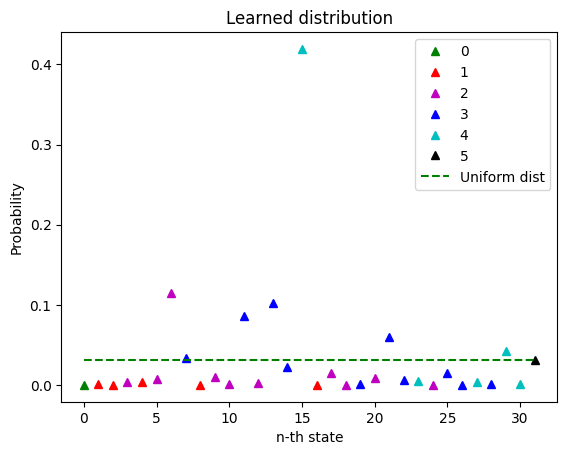

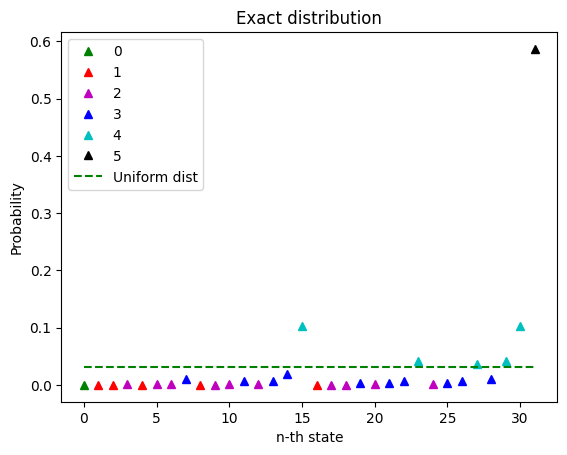


Results for W = I + 1's first row
##################################

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Partition function Z = 82036.609375
Epoch 0: error is 6173.958646351049
Epoch 1: error is 5896.354792903849
Epoch 2: error is 5656.664588899677
Epoch 3: error is 5443.41376216912
Epoch 4: error is 5260.273010781523
Epoch 5: error is 5111.4550646061425
Epoch 6: error is 4981.618819469965
Epoch 7: error is 4873.487709862169
Epoch 8: error is 4789.2604169369815
Epoch 9: error is 4720.403262829042
Epoch 10: error is 4655.083208439396
Epoch 11: error is 4613.543503904917
Epoch 12: error is 4571.948627559015
Epoch 13: error is 4539.027280313182
Epoch 14: error is 4514.6013955739145
Epoch 15: error is 4493.346687899252
Epoch 16: error is 4464.950619717977
Epoch 17: error is 4453.367943379988
Epoch 18: error is 4442.0146674375455
Epoch 19: error is 4434.709377553248
Epoch 20: error is 4423.935928168869
Epoch 21: error is 4416.9638217797155
Epoch 22: error 

Epoch 232: error is 4345.856900179339
Epoch 233: error is 4346.072981390789
Epoch 234: error is 4350.33708734098
Epoch 235: error is 4351.6775782685745
Epoch 236: error is 4355.8441436066405
Epoch 237: error is 4347.5303375353315
Epoch 238: error is 4347.0560683632575
Epoch 239: error is 4350.744563998516
Epoch 240: error is 4352.266180515492
Epoch 241: error is 4345.986239461028
Epoch 242: error is 4352.956638089814
Epoch 243: error is 4351.063232792514
Epoch 244: error is 4358.180854357144
Epoch 245: error is 4349.116555331678
Epoch 246: error is 4335.695373447545
Epoch 247: error is 4353.8307136605845
Epoch 248: error is 4342.369211376557
Epoch 249: error is 4348.218701118435
Epoch 250: error is 4349.780656978161
Epoch 251: error is 4351.74043455123
Epoch 252: error is 4345.374806770464
Epoch 253: error is 4350.870177976547
Epoch 254: error is 4342.544927483443
Epoch 255: error is 4346.891447944746
Epoch 256: error is 4344.129999502012
Epoch 257: error is 4344.523885069533
Epoch 258

Epoch 475: error is 4272.054522951772
Epoch 476: error is 4264.107663853732
Epoch 477: error is 4260.423220539334
Epoch 478: error is 4255.789823223698
Epoch 479: error is 4258.947234640216
Epoch 480: error is 4264.684797366865
Epoch 481: error is 4262.42223822045
Epoch 482: error is 4254.40103488695
Epoch 483: error is 4264.519722134462
Epoch 484: error is 4265.193082520098
Epoch 485: error is 4260.294678163247
Epoch 486: error is 4268.346285676116
Epoch 487: error is 4252.091937259393
Epoch 488: error is 4242.266872215002
Epoch 489: error is 4252.009328991895
Epoch 490: error is 4234.929919795199
Epoch 491: error is 4259.209715007309
Epoch 492: error is 4254.599971823488
Epoch 493: error is 4241.107790027081
Epoch 494: error is 4229.84314835073
Epoch 495: error is 4239.574631880776
Epoch 496: error is 4228.672816039393
Epoch 497: error is 4241.0888145398
Epoch 498: error is 4258.739730875874
Epoch 499: error is 4233.267156911107
Epoch 500: error is 4249.3085988254215
Epoch 501: error

Epoch 713: error is 3904.7632908178766
Epoch 714: error is 3921.255989710179
Epoch 715: error is 3899.717364214292
Epoch 716: error is 3926.245934738326
Epoch 717: error is 3891.4665097323045
Epoch 718: error is 3878.3049199723796
Epoch 719: error is 3870.417384497234
Epoch 720: error is 3898.147829522455
Epoch 721: error is 3890.9689584707407
Epoch 722: error is 3864.175384454047
Epoch 723: error is 3846.9226831617484
Epoch 724: error is 3863.1295889899325
Epoch 725: error is 3878.670363299284
Epoch 726: error is 3866.5848773381513
Epoch 727: error is 3858.062454372334
Epoch 728: error is 3898.128070293623
Epoch 729: error is 3846.2891418363906
Epoch 730: error is 3853.168034848996
Epoch 731: error is 3836.5746237314597
Epoch 732: error is 3826.6428909842643
Epoch 733: error is 3841.5505048392642
Epoch 734: error is 3821.909860415149
Epoch 735: error is 3825.1883169178936
Epoch 736: error is 3867.6571173438247
Epoch 737: error is 3795.1879090623124
Epoch 738: error is 3808.90123580418

Epoch 958: error is 3214.131158329791
Epoch 959: error is 3246.784404818383
Epoch 960: error is 3243.096722362435
Epoch 961: error is 3282.9379792315603
Epoch 962: error is 3226.075764264456
Epoch 963: error is 3202.250274847193
Epoch 964: error is 3218.4962871552534
Epoch 965: error is 3181.4110950296445
Epoch 966: error is 3220.8728858510776
Epoch 967: error is 3200.289271611939
Epoch 968: error is 3185.1885852260034
Epoch 969: error is 3191.5796269784123
Epoch 970: error is 3209.036050552433
Epoch 971: error is 3203.511168137925
Epoch 972: error is 3207.3267372335577
Epoch 973: error is 3189.6383635646157
Epoch 974: error is 3171.1628127622553
Epoch 975: error is 3162.5879192481234
Epoch 976: error is 3177.9093363978527
Epoch 977: error is 3205.936133607424
Epoch 978: error is 3206.661813190307
Epoch 979: error is 3149.86448088962
Epoch 980: error is 3197.1151966883094
Epoch 981: error is 3174.8290633416354
Epoch 982: error is 3156.10094871247
Epoch 983: error is 3173.4549285795492


Epoch 1202: error is 2634.047805298787
Epoch 1203: error is 2635.99031800944
Epoch 1204: error is 2642.9009982323005
Epoch 1205: error is 2596.736817433437
Epoch 1206: error is 2592.673055747772
Epoch 1207: error is 2595.0118859104878
Epoch 1208: error is 2610.0149420784774
Epoch 1209: error is 2639.048926118008
Epoch 1210: error is 2616.0220186659626
Epoch 1211: error is 2562.6895860621294
Epoch 1212: error is 2591.1794385942676
Epoch 1213: error is 2619.863506139371
Epoch 1214: error is 2637.5464701338424
Epoch 1215: error is 2625.690595727298
Epoch 1216: error is 2582.5375169974677
Epoch 1217: error is 2581.4902773361628
Epoch 1218: error is 2624.9327771692792
Epoch 1219: error is 2606.8345998866107
Epoch 1220: error is 2604.287404984295
Epoch 1221: error is 2611.0736853125445
Epoch 1222: error is 2555.994302357328
Epoch 1223: error is 2569.7181065185223
Epoch 1224: error is 2514.4097322560074
Epoch 1225: error is 2582.9329389334794
Epoch 1226: error is 2596.294423440566
Epoch 1227:

Epoch 1441: error is 2161.879561261777
Epoch 1442: error is 2178.726187178214
Epoch 1443: error is 2207.8120791723873
Epoch 1444: error is 2234.701876355089
Epoch 1445: error is 2232.1027025905364
Epoch 1446: error is 2182.8887296181247
Epoch 1447: error is 2203.2112186779264
Epoch 1448: error is 2192.2481622030746
Epoch 1449: error is 2198.787245288516
Epoch 1450: error is 2155.7303056599258
Epoch 1451: error is 2234.434267333953
Epoch 1452: error is 2162.635255155422
Epoch 1453: error is 2176.911427063036
Epoch 1454: error is 2182.0692665233337
Epoch 1455: error is 2170.3884472814707
Epoch 1456: error is 2217.9400793413897
Epoch 1457: error is 2181.5194946090946
Epoch 1458: error is 2206.2742403631137
Epoch 1459: error is 2153.8093362272393
Epoch 1460: error is 2145.87775377449
Epoch 1461: error is 2167.833041255797
Epoch 1462: error is 2134.8074179528912
Epoch 1463: error is 2146.9258439031905
Epoch 1464: error is 2178.1273257879875
Epoch 1465: error is 2184.9123496587968
Epoch 1466

Epoch 1744: error is 1764.9339489024048
Epoch 1745: error is 1796.7607771367748
Epoch 1746: error is 1798.560191409765
Epoch 1747: error is 1840.6295070255571
Epoch 1748: error is 1833.4725515912253
Epoch 1749: error is 1808.9871294502666
Epoch 1750: error is 1809.037872012692
Epoch 1751: error is 1771.3136501224303
Epoch 1752: error is 1787.1354331183381
Epoch 1753: error is 1789.1894237590332
Epoch 1754: error is 1790.454635677946
Epoch 1755: error is 1779.2708498288212
Epoch 1756: error is 1785.8641064901467
Epoch 1757: error is 1782.5206955540082
Epoch 1758: error is 1800.621878512325
Epoch 1759: error is 1749.6924999901603
Epoch 1760: error is 1798.2075650221145
Epoch 1761: error is 1812.8387979772647
Epoch 1762: error is 1823.407835583007
Epoch 1763: error is 1818.2848755071564
Epoch 1764: error is 1805.248113705727
Epoch 1765: error is 1828.1747448699136
Epoch 1766: error is 1790.5475497830132
Epoch 1767: error is 1758.5229343216677
Epoch 1768: error is 1734.0470353242208
Epoch 

Epoch 2000: error is 1595.4379359123561
Epoch 2001: error is 1607.4479004062746
Epoch 2002: error is 1604.3460386913266
Epoch 2003: error is 1580.4759862564033
Epoch 2004: error is 1601.4871347289454
Epoch 2005: error is 1563.3941727703423
Epoch 2006: error is 1621.4978785598523
Epoch 2007: error is 1537.9508069662452
Epoch 2008: error is 1609.4567759188
Epoch 2009: error is 1530.5332393540098
Epoch 2010: error is 1588.5562199394126
Epoch 2011: error is 1546.3119124680159
Epoch 2012: error is 1581.9899206392747
Epoch 2013: error is 1599.7172034664547
Epoch 2014: error is 1556.2383956777633
Epoch 2015: error is 1607.1255834147455
Epoch 2016: error is 1546.0386375074704
Epoch 2017: error is 1602.9260903962418
Epoch 2018: error is 1559.0871730823314
Epoch 2019: error is 1564.5635423810122
Epoch 2020: error is 1560.4117691169404
Epoch 2021: error is 1617.2592979323658
Epoch 2022: error is 1582.2351183693365
Epoch 2023: error is 1537.7474029968344
Epoch 2024: error is 1538.0951485133066
Epo

Epoch 2222: error is 1418.5620080771505
Epoch 2223: error is 1436.1488139839273
Epoch 2224: error is 1402.4593123584289
Epoch 2225: error is 1448.7840025752637
Epoch 2226: error is 1443.5733310159644
Epoch 2227: error is 1443.6096809357146
Epoch 2228: error is 1412.8227320830956
Epoch 2229: error is 1370.940330853734
Epoch 2230: error is 1401.1133953196213
Epoch 2231: error is 1420.1800788644334
Epoch 2232: error is 1401.1635781813275
Epoch 2233: error is 1443.5021735023483
Epoch 2234: error is 1442.4495355218285
Epoch 2235: error is 1444.9725237644748
Epoch 2236: error is 1434.6911135828286
Epoch 2237: error is 1420.4876656882698
Epoch 2238: error is 1403.63697786222
Epoch 2239: error is 1411.306371462808
Epoch 2240: error is 1433.270520380901
Epoch 2241: error is 1409.0596832226395
Epoch 2242: error is 1405.1229131943992
Epoch 2243: error is 1449.2396923314202
Epoch 2244: error is 1377.468832870806
Epoch 2245: error is 1411.336270342412
Epoch 2246: error is 1399.5780581084327
Epoch 2

Epoch 2444: error is 1343.4726817523706
Epoch 2445: error is 1345.750839140136
Epoch 2446: error is 1282.6852974134974
Epoch 2447: error is 1280.3265052435777
Epoch 2448: error is 1292.7825158115118
Epoch 2449: error is 1279.1192635353923
Epoch 2450: error is 1302.7445700744354
Epoch 2451: error is 1305.3340636585142
Epoch 2452: error is 1315.4226150439715
Epoch 2453: error is 1297.9192072465025
Epoch 2454: error is 1298.49863037084
Epoch 2455: error is 1282.5884736137689
Epoch 2456: error is 1304.3334060765442
Epoch 2457: error is 1325.1985800705215
Epoch 2458: error is 1307.390583020285
Epoch 2459: error is 1250.378210603802
Epoch 2460: error is 1288.9882771004723
Epoch 2461: error is 1263.2899713760728
Epoch 2462: error is 1291.7915265249353
Epoch 2463: error is 1283.2641374751877
Epoch 2464: error is 1291.6151716475797
Epoch 2465: error is 1271.4177655211859
Epoch 2466: error is 1280.9810028279312
Epoch 2467: error is 1285.2512673592282
Epoch 2468: error is 1278.8883056019106
Epoch

Epoch 2663: error is 1200.164389042527
Epoch 2664: error is 1199.7594949389788
Epoch 2665: error is 1182.9316894964434
Epoch 2666: error is 1170.2981677129405
Epoch 2667: error is 1201.5536270081166
Epoch 2668: error is 1181.4675010225562
Epoch 2669: error is 1161.1399954434219
Epoch 2670: error is 1184.029237559272
Epoch 2671: error is 1176.3132360996258
Epoch 2672: error is 1209.9932052635709
Epoch 2673: error is 1165.3907004101954
Epoch 2674: error is 1192.7808831102438
Epoch 2675: error is 1169.5729293247655
Epoch 2676: error is 1196.749707181421
Epoch 2677: error is 1161.3712488685403
Epoch 2678: error is 1180.241486873991
Epoch 2679: error is 1203.063697937282
Epoch 2680: error is 1187.955060858414
Epoch 2681: error is 1208.3974834258565
Epoch 2682: error is 1205.3665633705245
Epoch 2683: error is 1214.1921789185662
Epoch 2684: error is 1188.492037917952
Epoch 2685: error is 1173.8551177295772
Epoch 2686: error is 1178.20380811833
Epoch 2687: error is 1165.5162298324042
Epoch 268

Epoch 2903: error is 1088.712557360997
Epoch 2904: error is 1089.6374950217378
Epoch 2905: error is 1131.0916173243527
Epoch 2906: error is 1124.7430939461747
Epoch 2907: error is 1075.1264845094263
Epoch 2908: error is 1085.9137036792408
Epoch 2909: error is 1076.6262470016632
Epoch 2910: error is 1124.6967070341898
Epoch 2911: error is 1105.4898204432773
Epoch 2912: error is 1095.1520057477003
Epoch 2913: error is 1102.8479967035428
Epoch 2914: error is 1109.6445726055058
Epoch 2915: error is 1097.5323429176356
Epoch 2916: error is 1090.9101186476878
Epoch 2917: error is 1111.5107417927702
Epoch 2918: error is 1102.8469084912244
Epoch 2919: error is 1098.3529217475734
Epoch 2920: error is 1088.197186307596
Epoch 2921: error is 1096.52173122033
Epoch 2922: error is 1071.5896176509
Epoch 2923: error is 1036.7667814533024
Epoch 2924: error is 1060.6266547206233
Epoch 2925: error is 1087.7512515410185
Epoch 2926: error is 1070.4308371052448
Epoch 2927: error is 1064.1968778953212
Epoch 2

Epoch 3145: error is 1002.5539358602787
Epoch 3146: error is 1001.7037188577981
Epoch 3147: error is 1006.4209821304023
Epoch 3148: error is 1011.9062209123199
Epoch 3149: error is 1026.9149144637568
Epoch 3150: error is 1051.8024546465067
Epoch 3151: error is 1013.9755551684929
Epoch 3152: error is 1045.2976287963215
Epoch 3153: error is 1020.5759843419446
Epoch 3154: error is 1019.054893738807
Epoch 3155: error is 1024.0342424014607
Epoch 3156: error is 1014.2898353969422
Epoch 3157: error is 1019.1979627174982
Epoch 3158: error is 1015.524894226357
Epoch 3159: error is 1004.9300726122822
Epoch 3160: error is 992.5045037972972
Epoch 3161: error is 1039.0899679415809
Epoch 3162: error is 1001.7996552395841
Epoch 3163: error is 1028.3065684711148
Epoch 3164: error is 1045.2863572641825
Epoch 3165: error is 989.5965648669747
Epoch 3166: error is 998.1326691991303
Epoch 3167: error is 1046.2083155462606
Epoch 3168: error is 1011.3691799154935
Epoch 3169: error is 1029.7146579010705
Epoch

Epoch 3386: error is 950.1470702157363
Epoch 3387: error is 961.2517295747627
Epoch 3388: error is 945.3319565896754
Epoch 3389: error is 934.4943512943553
Epoch 3390: error is 961.3192357107112
Epoch 3391: error is 950.1916632686081
Epoch 3392: error is 919.7235968135473
Epoch 3393: error is 972.7438346884106
Epoch 3394: error is 950.2342562663706
Epoch 3395: error is 966.0878573816319
Epoch 3396: error is 980.2124045595546
Epoch 3397: error is 941.5210349283477
Epoch 3398: error is 946.1808623673382
Epoch 3399: error is 955.4146408693682
Epoch 3400: error is 970.0576893524869
Epoch 3401: error is 971.9598979930132
Epoch 3402: error is 949.3337428661907
Epoch 3403: error is 942.0377048130687
Epoch 3404: error is 967.4654337472818
Epoch 3405: error is 947.5702944882464
Epoch 3406: error is 957.9679464773671
Epoch 3407: error is 909.6607719781009
Epoch 3408: error is 931.9260677671004
Epoch 3409: error is 972.2389734911034
Epoch 3410: error is 930.6098304781882
Epoch 3411: error is 948.

Epoch 3626: error is 867.9526581590655
Epoch 3627: error is 910.3404694080748
Epoch 3628: error is 883.8933197696699
Epoch 3629: error is 875.1859148657925
Epoch 3630: error is 919.848814900105
Epoch 3631: error is 894.9271264007073
Epoch 3632: error is 864.2905357748298
Epoch 3633: error is 872.4217359490361
Epoch 3634: error is 868.7884344721077
Epoch 3635: error is 885.9877848189016
Epoch 3636: error is 864.5082815112764
Epoch 3637: error is 861.6057159641608
Epoch 3638: error is 885.7415417793721
Epoch 3639: error is 858.7628789781666
Epoch 3640: error is 891.0101189569098
Epoch 3641: error is 871.9213507456357
Epoch 3642: error is 899.5181512747495
Epoch 3643: error is 840.3309859561505
Epoch 3644: error is 891.0086353809481
Epoch 3645: error is 929.5933620005592
Epoch 3646: error is 830.7390139358645
Epoch 3647: error is 874.7929165897859
Epoch 3648: error is 871.2623842390765
Epoch 3649: error is 867.5667058718291
Epoch 3650: error is 895.337651856133
Epoch 3651: error is 856.93

Epoch 3867: error is 815.283234520151
Epoch 3868: error is 844.2597822975106
Epoch 3869: error is 838.867850300503
Epoch 3870: error is 809.0571335629388
Epoch 3871: error is 817.2550137682072
Epoch 3872: error is 825.699727300093
Epoch 3873: error is 849.7705330214591
Epoch 3874: error is 858.2390143690263
Epoch 3875: error is 842.3892266621999
Epoch 3876: error is 828.1604753057153
Epoch 3877: error is 825.5063535906129
Epoch 3878: error is 800.3602542194582
Epoch 3879: error is 824.0608373943346
Epoch 3880: error is 825.7837710520666
Epoch 3881: error is 830.7655069036879
Epoch 3882: error is 824.6127007483649
Epoch 3883: error is 821.6849968338973
Epoch 3884: error is 818.7426656936615
Epoch 3885: error is 842.7348919887595
Epoch 3886: error is 820.5356811710767
Epoch 3887: error is 846.4433546278544
Epoch 3888: error is 825.285085071441
Epoch 3889: error is 848.3096118994241
Epoch 3890: error is 799.3673089636777
Epoch 3891: error is 816.3836482711667
Epoch 3892: error is 807.4794

Epoch 4106: error is 788.526351911876
Epoch 4107: error is 748.7732732862169
Epoch 4108: error is 781.1702892166409
Epoch 4109: error is 778.231134618733
Epoch 4110: error is 760.942494409807
Epoch 4111: error is 775.6570400911381
Epoch 4112: error is 772.878519427466
Epoch 4113: error is 771.0460556497194
Epoch 4114: error is 789.8901469668792
Epoch 4115: error is 796.0659147132566
Epoch 4116: error is 743.3155366905755
Epoch 4117: error is 752.9068707843915
Epoch 4118: error is 757.5109715752908
Epoch 4119: error is 728.2200218225614
Epoch 4120: error is 772.7845397762387
Epoch 4121: error is 757.8063962850308
Epoch 4122: error is 736.4429944685623
Epoch 4123: error is 756.3796058784894
Epoch 4124: error is 756.1046954503369
Epoch 4125: error is 764.1512592936906
Epoch 4126: error is 758.0569040902982
Epoch 4127: error is 733.6991616103087
Epoch 4128: error is 754.2465106122896
Epoch 4129: error is 754.9235691966082
Epoch 4130: error is 769.8269976619551
Epoch 4131: error is 780.0048

Epoch 4345: error is 693.770672265595
Epoch 4346: error is 688.7801447769616
Epoch 4347: error is 710.7796793662387
Epoch 4348: error is 710.8477030115313
Epoch 4349: error is 711.9180241241579
Epoch 4350: error is 687.4849409244371
Epoch 4351: error is 717.6735880408132
Epoch 4352: error is 690.5487030948791
Epoch 4353: error is 715.1729382822118
Epoch 4354: error is 686.5568552721887
Epoch 4355: error is 690.6485812319152
Epoch 4356: error is 730.49471196456
Epoch 4357: error is 719.9933077331372
Epoch 4358: error is 733.7125722543394
Epoch 4359: error is 689.5377844322892
Epoch 4360: error is 709.5846380903581
Epoch 4361: error is 692.2857633338865
Epoch 4362: error is 715.8725390006508
Epoch 4363: error is 697.9799984615088
Epoch 4364: error is 703.4911215991855
Epoch 4365: error is 721.689465523417
Epoch 4366: error is 728.5047595651381
Epoch 4367: error is 698.475434728662
Epoch 4368: error is 729.974209668308
Epoch 4369: error is 694.914889776981
Epoch 4370: error is 701.5452375

Epoch 4590: error is 674.2366677322295
Epoch 4591: error is 651.7819295042056
Epoch 4592: error is 643.9631032228963
Epoch 4593: error is 637.2387023375508
Epoch 4594: error is 651.80714096195
Epoch 4595: error is 654.7505066676889
Epoch 4596: error is 651.6017674192548
Epoch 4597: error is 633.069262745818
Epoch 4598: error is 640.0926094993162
Epoch 4599: error is 653.4278485378146
Epoch 4600: error is 633.1763253054894
Epoch 4601: error is 642.2481198124519
Epoch 4602: error is 653.9709947347043
Epoch 4603: error is 619.3287817646585
Epoch 4604: error is 675.0843760417476
Epoch 4605: error is 654.9964547964886
Epoch 4606: error is 645.6538786136066
Epoch 4607: error is 645.4933708561608
Epoch 4608: error is 657.9757245923272
Epoch 4609: error is 644.9714399626589
Epoch 4610: error is 629.1595197051188
Epoch 4611: error is 644.4075929117027
Epoch 4612: error is 670.6047479020924
Epoch 4613: error is 656.4430914547926
Epoch 4614: error is 642.9352331876231
Epoch 4615: error is 647.218

Epoch 4834: error is 598.1343013466218
Epoch 4835: error is 581.8733166245536
Epoch 4836: error is 580.1320918730703
Epoch 4837: error is 590.7633117531623
Epoch 4838: error is 576.377829347474
Epoch 4839: error is 580.7075796794495
Epoch 4840: error is 602.1911200307321
Epoch 4841: error is 595.0704463193247
Epoch 4842: error is 583.8859978456368
Epoch 4843: error is 597.0891680036332
Epoch 4844: error is 577.8035180736459
Epoch 4845: error is 586.1814951677947
Epoch 4846: error is 610.8526746372061
Epoch 4847: error is 605.2787572579839
Epoch 4848: error is 592.8279742176927
Epoch 4849: error is 590.4986904950525
Epoch 4850: error is 587.6374102264508
Epoch 4851: error is 594.0404929868541
Epoch 4852: error is 604.3962495791368
Epoch 4853: error is 583.8386650771317
Epoch 4854: error is 612.0790197348351
Epoch 4855: error is 603.7675131429156
Epoch 4856: error is 593.2209600723936
Epoch 4857: error is 567.5369090961931
Epoch 4858: error is 584.0746734724039
Epoch 4859: error is 591.1

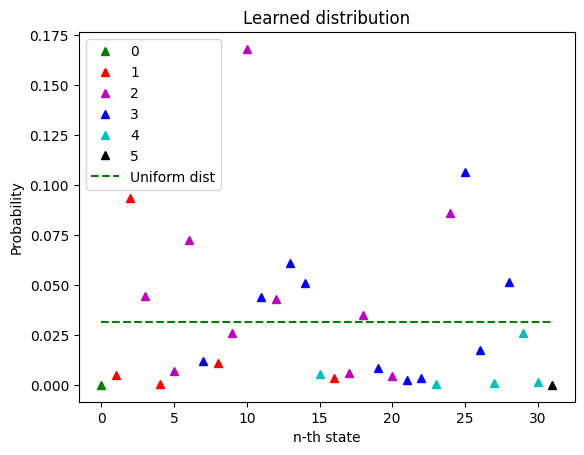

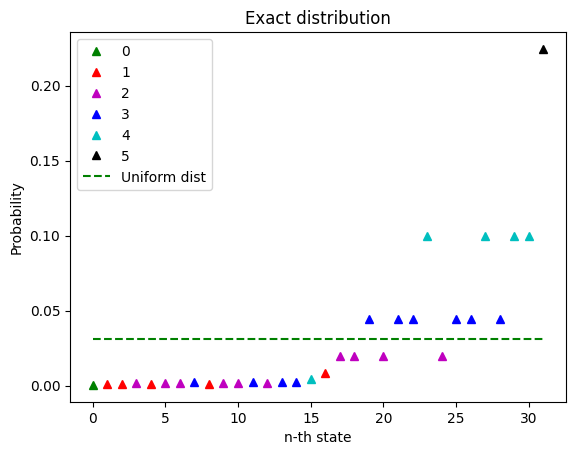


Results for W = I + 1's first column
##################################

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Partition function Z = 82036.609375
Epoch 0: error is 6165.340678946848
Epoch 1: error is 5818.301922916082
Epoch 2: error is 5504.520146248769
Epoch 3: error is 5231.691325093549
Epoch 4: error is 4992.412736778067
Epoch 5: error is 4781.187150198423
Epoch 6: error is 4621.0858589884265
Epoch 7: error is 4470.796469043136
Epoch 8: error is 4361.241245360285
Epoch 9: error is 4263.514516136896
Epoch 10: error is 4176.269017183699
Epoch 11: error is 4120.321758449198
Epoch 12: error is 4060.646483421178
Epoch 13: error is 4011.61194506055
Epoch 14: error is 3983.3906588638456
Epoch 15: error is 3957.991479028435
Epoch 16: error is 3937.923972730352
Epoch 17: error is 3908.569333702589
Epoch 18: error is 3902.4677603422883
Epoch 19: error is 3890.8238799198643
Epoch 20: error is 3885.2971175699927
Epoch 21: error is 3869.8347800281645
Epoch 22: er

Epoch 237: error is 3836.590497333685
Epoch 238: error is 3832.551837632297
Epoch 239: error is 3842.9303702841053
Epoch 240: error is 3842.7807792667554
Epoch 241: error is 3845.676806945197
Epoch 242: error is 3845.539216727647
Epoch 243: error is 3841.4565262923315
Epoch 244: error is 3840.164323021353
Epoch 245: error is 3831.788212259155
Epoch 246: error is 3834.1494506226363
Epoch 247: error is 3840.4036167717286
Epoch 248: error is 3841.147765769737
Epoch 249: error is 3845.404788274056
Epoch 250: error is 3837.9136213526695
Epoch 251: error is 3839.4774362465496
Epoch 252: error is 3836.048587774775
Epoch 253: error is 3842.404862712612
Epoch 254: error is 3846.9207147316174
Epoch 255: error is 3839.1257074524497
Epoch 256: error is 3840.3801104807835
Epoch 257: error is 3838.281609842857
Epoch 258: error is 3841.096359600393
Epoch 259: error is 3839.869665360819
Epoch 260: error is 3844.3584910138593
Epoch 261: error is 3838.6649103440704
Epoch 262: error is 3833.60041459052
E

Epoch 485: error is 3816.369352902158
Epoch 486: error is 3819.007925761431
Epoch 487: error is 3822.069590631512
Epoch 488: error is 3811.0685173765614
Epoch 489: error is 3815.589592773885
Epoch 490: error is 3822.24873931499
Epoch 491: error is 3816.6798925150624
Epoch 492: error is 3821.6764319400745
Epoch 493: error is 3826.0689308347173
Epoch 494: error is 3819.7930510266774
Epoch 495: error is 3830.4441758676635
Epoch 496: error is 3820.393446478445
Epoch 497: error is 3817.5102913370733
Epoch 498: error is 3812.760638093003
Epoch 499: error is 3815.4473371104586
Epoch 500: error is 3811.9471353566705
Epoch 501: error is 3822.708503182095
Epoch 502: error is 3818.7130079464832
Epoch 503: error is 3822.197270189702
Epoch 504: error is 3812.555223861782
Epoch 505: error is 3823.4231043316977
Epoch 506: error is 3818.410991844191
Epoch 507: error is 3817.9045604108846
Epoch 508: error is 3820.396590623485
Epoch 509: error is 3813.631061890714
Epoch 510: error is 3827.8284320753514


Epoch 717: error is 3711.6715771082113
Epoch 718: error is 3733.5197901610045
Epoch 719: error is 3711.8068566042857
Epoch 720: error is 3696.3296431921053
Epoch 721: error is 3723.651849362568
Epoch 722: error is 3707.947563020007
Epoch 723: error is 3692.833626824724
Epoch 724: error is 3728.70548943202
Epoch 725: error is 3702.2858796195865
Epoch 726: error is 3709.281716421792
Epoch 727: error is 3715.7234941631923
Epoch 728: error is 3718.5154326827455
Epoch 729: error is 3710.554508941981
Epoch 730: error is 3689.9158492331057
Epoch 731: error is 3696.235599170321
Epoch 732: error is 3704.027451791011
Epoch 733: error is 3699.151664713726
Epoch 734: error is 3703.4013063246484
Epoch 735: error is 3710.4450586441308
Epoch 736: error is 3689.3066104137797
Epoch 737: error is 3696.612235343151
Epoch 738: error is 3687.4242355822694
Epoch 739: error is 3689.2449255211836
Epoch 740: error is 3702.5087765072017
Epoch 741: error is 3703.016120298245
Epoch 742: error is 3703.396048289138

Epoch 962: error is 3364.9021177961326
Epoch 963: error is 3360.7932599976502
Epoch 964: error is 3370.0587786240408
Epoch 965: error is 3378.569086819911
Epoch 966: error is 3366.4134631090164
Epoch 967: error is 3360.862007372749
Epoch 968: error is 3356.946458261773
Epoch 969: error is 3364.5705666523545
Epoch 970: error is 3325.433458494948
Epoch 971: error is 3362.452326578975
Epoch 972: error is 3356.2896343147518
Epoch 973: error is 3343.596126100415
Epoch 974: error is 3345.4963739183004
Epoch 975: error is 3362.2417000496835
Epoch 976: error is 3356.616493259278
Epoch 977: error is 3335.6045030333885
Epoch 978: error is 3347.8328730472595
Epoch 979: error is 3359.370533423904
Epoch 980: error is 3324.647402666864
Epoch 981: error is 3348.2407187417716
Epoch 982: error is 3336.1507221255997
Epoch 983: error is 3287.8058946369465
Epoch 984: error is 3316.809025957105
Epoch 985: error is 3305.4139563536714
Epoch 986: error is 3331.2575968620145
Epoch 987: error is 3325.7542740778

Epoch 1205: error is 2966.420112780534
Epoch 1206: error is 2926.319553848333
Epoch 1207: error is 2957.4294843625994
Epoch 1208: error is 2946.1094761842523
Epoch 1209: error is 2942.460476356814
Epoch 1210: error is 2932.5972633131055
Epoch 1211: error is 2887.02512137139
Epoch 1212: error is 2941.9489961095187
Epoch 1213: error is 2890.3633161891166
Epoch 1214: error is 2939.0669905034447
Epoch 1215: error is 2940.4370375215194
Epoch 1216: error is 2910.861875143903
Epoch 1217: error is 2909.144586938162
Epoch 1218: error is 2927.5146344348236
Epoch 1219: error is 2917.8305671003436
Epoch 1220: error is 2914.424941677332
Epoch 1221: error is 2928.52322060552
Epoch 1222: error is 2891.5225615982918
Epoch 1223: error is 2924.728677819737
Epoch 1224: error is 2869.0423741265777
Epoch 1225: error is 2914.27220618807
Epoch 1226: error is 2949.4929797920827
Epoch 1227: error is 2867.6046276913125
Epoch 1228: error is 2903.6202929898873
Epoch 1229: error is 2920.3944333761947
Epoch 1230: e

Epoch 1452: error is 2587.2888741722963
Epoch 1453: error is 2534.09031295535
Epoch 1454: error is 2587.604457534302
Epoch 1455: error is 2539.688264238152
Epoch 1456: error is 2547.196394480862
Epoch 1457: error is 2547.0688684236434
Epoch 1458: error is 2556.1040199941576
Epoch 1459: error is 2505.1720935142944
Epoch 1460: error is 2524.603100681085
Epoch 1461: error is 2532.07602881586
Epoch 1462: error is 2529.077027750014
Epoch 1463: error is 2533.941741438069
Epoch 1464: error is 2549.897255460162
Epoch 1465: error is 2525.3756418255325
Epoch 1466: error is 2554.5951949217792
Epoch 1467: error is 2543.461474586301
Epoch 1468: error is 2513.922076700135
Epoch 1469: error is 2507.16465011234
Epoch 1470: error is 2496.729202002278
Epoch 1471: error is 2528.9949419058175
Epoch 1472: error is 2550.9708797368535
Epoch 1473: error is 2564.0649855788038
Epoch 1474: error is 2531.183635179296
Epoch 1475: error is 2509.6184497252525
Epoch 1476: error is 2515.0989143354036
Epoch 1477: error

Epoch 1698: error is 2226.6382067162076
Epoch 1699: error is 2231.854112053772
Epoch 1700: error is 2205.7403362786467
Epoch 1701: error is 2207.0276970755276
Epoch 1702: error is 2198.109104657001
Epoch 1703: error is 2212.4753807138172
Epoch 1704: error is 2213.1081148714106
Epoch 1705: error is 2195.950424156763
Epoch 1706: error is 2166.942318302417
Epoch 1707: error is 2185.0543578801326
Epoch 1708: error is 2216.2320668540547
Epoch 1709: error is 2186.8660237114427
Epoch 1710: error is 2209.0451966324845
Epoch 1711: error is 2184.1251613910813
Epoch 1712: error is 2178.1520177762313
Epoch 1713: error is 2158.5150137673036
Epoch 1714: error is 2159.648524476284
Epoch 1715: error is 2172.820944732891
Epoch 1716: error is 2180.87361577672
Epoch 1717: error is 2195.2278140592944
Epoch 1718: error is 2158.425043400919
Epoch 1719: error is 2187.3529412808302
Epoch 1720: error is 2157.3452967356443
Epoch 1721: error is 2202.7088473258223
Epoch 1722: error is 2160.0178807357365
Epoch 172

Epoch 1942: error is 1936.3237858452494
Epoch 1943: error is 1922.5383663661553
Epoch 1944: error is 1972.601461158264
Epoch 1945: error is 1951.0717810448239
Epoch 1946: error is 1969.7586123210854
Epoch 1947: error is 1937.6870088395683
Epoch 1948: error is 1939.032412981221
Epoch 1949: error is 1898.1820416481742
Epoch 1950: error is 1941.7522480887733
Epoch 1951: error is 1917.4248510089778
Epoch 1952: error is 1901.366257082935
Epoch 1953: error is 1921.1411686144384
Epoch 1954: error is 1882.6209593081958
Epoch 1955: error is 1922.4300491700346
Epoch 1956: error is 1925.4464869232097
Epoch 1957: error is 1956.5286410473773
Epoch 1958: error is 1944.9928154867582
Epoch 1959: error is 1921.8035653847512
Epoch 1960: error is 1955.9483620132187
Epoch 1961: error is 1929.0910225042126
Epoch 1962: error is 1906.3873997962055
Epoch 1963: error is 1907.8192381555384
Epoch 1964: error is 1960.5241557959957
Epoch 1965: error is 1941.0329273529426
Epoch 1966: error is 1873.2631015629663
Epo

Epoch 2190: error is 1726.5229290211792
Epoch 2191: error is 1762.545929221311
Epoch 2192: error is 1772.5583269838064
Epoch 2193: error is 1728.8076597213894
Epoch 2194: error is 1715.4009997581932
Epoch 2195: error is 1726.6468854442232
Epoch 2196: error is 1716.4588468513246
Epoch 2197: error is 1786.1539177743707
Epoch 2198: error is 1727.2804196369784
Epoch 2199: error is 1715.7730418344095
Epoch 2200: error is 1747.4252106020658
Epoch 2201: error is 1744.7977281551205
Epoch 2202: error is 1742.2724821361128
Epoch 2203: error is 1729.7423834097958
Epoch 2204: error is 1777.400367366412
Epoch 2205: error is 1686.6664459912326
Epoch 2206: error is 1712.8234043797497
Epoch 2207: error is 1689.1084310052
Epoch 2208: error is 1743.016127424053
Epoch 2209: error is 1707.6437625692995
Epoch 2210: error is 1702.4562898393199
Epoch 2211: error is 1708.4025054480148
Epoch 2212: error is 1746.1351055592386
Epoch 2213: error is 1725.9038249318064
Epoch 2214: error is 1773.4824408311051
Epoch 

Epoch 2435: error is 1583.3717105838427
Epoch 2436: error is 1584.2862223901263
Epoch 2437: error is 1566.5655327291597
Epoch 2438: error is 1564.3035013557328
Epoch 2439: error is 1555.452965667585
Epoch 2440: error is 1584.8483092347658
Epoch 2441: error is 1571.517293811312
Epoch 2442: error is 1556.6773629263648
Epoch 2443: error is 1588.3984227767098
Epoch 2444: error is 1539.8205772861515
Epoch 2445: error is 1534.5428040286324
Epoch 2446: error is 1560.736863493879
Epoch 2447: error is 1580.7917905284921
Epoch 2448: error is 1555.0099205982642
Epoch 2449: error is 1558.3559700348821
Epoch 2450: error is 1536.9163744677448
Epoch 2451: error is 1548.4995315712836
Epoch 2452: error is 1578.5241606519287
Epoch 2453: error is 1587.3920812888239
Epoch 2454: error is 1551.903502120746
Epoch 2455: error is 1573.014724132747
Epoch 2456: error is 1558.7569971977125
Epoch 2457: error is 1583.4835413032717
Epoch 2458: error is 1602.534851876386
Epoch 2459: error is 1551.7104178595516
Epoch 

Epoch 2682: error is 1418.3311934524259
Epoch 2683: error is 1380.5826479265486
Epoch 2684: error is 1441.235899293874
Epoch 2685: error is 1413.5967735753427
Epoch 2686: error is 1454.8685397642464
Epoch 2687: error is 1420.0117441425757
Epoch 2688: error is 1451.6824849035465
Epoch 2689: error is 1410.8284268377506
Epoch 2690: error is 1433.0156646708251
Epoch 2691: error is 1414.1195848860505
Epoch 2692: error is 1405.650465273917
Epoch 2693: error is 1459.8789083603886
Epoch 2694: error is 1417.379681453261
Epoch 2695: error is 1431.179118858246
Epoch 2696: error is 1479.8129273235572
Epoch 2697: error is 1400.0339345485359
Epoch 2698: error is 1432.498409405381
Epoch 2699: error is 1421.5018368538417
Epoch 2700: error is 1472.2111386495335
Epoch 2701: error is 1412.8846328389661
Epoch 2702: error is 1452.740197619041
Epoch 2703: error is 1373.1135497443495
Epoch 2704: error is 1457.1063790380908
Epoch 2705: error is 1389.5128620073215
Epoch 2706: error is 1416.948587368423
Epoch 2

Epoch 2920: error is 1324.1687913572619
Epoch 2921: error is 1327.337412623453
Epoch 2922: error is 1317.236965364209
Epoch 2923: error is 1318.0885483582342
Epoch 2924: error is 1308.7676220628248
Epoch 2925: error is 1313.8759438019745
Epoch 2926: error is 1306.209572240391
Epoch 2927: error is 1334.0535066392472
Epoch 2928: error is 1316.8466205587322
Epoch 2929: error is 1319.9290057439912
Epoch 2930: error is 1342.3919203100454
Epoch 2931: error is 1330.0949594027538
Epoch 2932: error is 1325.231693900675
Epoch 2933: error is 1327.050796588378
Epoch 2934: error is 1322.6419390675535
Epoch 2935: error is 1339.779700868931
Epoch 2936: error is 1308.7209586294493
Epoch 2937: error is 1310.3351202298809
Epoch 2938: error is 1306.5207776038199
Epoch 2939: error is 1335.0552148563515
Epoch 2940: error is 1314.8607404366458
Epoch 2941: error is 1337.9074228709503
Epoch 2942: error is 1313.2444112599828
Epoch 2943: error is 1311.423868841124
Epoch 2944: error is 1302.835724347784
Epoch 29

Epoch 3160: error is 1220.2254859356713
Epoch 3161: error is 1220.613650602579
Epoch 3162: error is 1241.5433658808336
Epoch 3163: error is 1217.7794816072999
Epoch 3164: error is 1234.703225078346
Epoch 3165: error is 1252.305214671123
Epoch 3166: error is 1218.241763836621
Epoch 3167: error is 1267.7199638584052
Epoch 3168: error is 1248.0146783906864
Epoch 3169: error is 1215.9169243700383
Epoch 3170: error is 1222.6926764765258
Epoch 3171: error is 1228.9191986164708
Epoch 3172: error is 1257.5087643932438
Epoch 3173: error is 1204.5282552266922
Epoch 3174: error is 1222.8144507915579
Epoch 3175: error is 1241.5531287002696
Epoch 3176: error is 1219.471449935945
Epoch 3177: error is 1223.2947510551057
Epoch 3178: error is 1198.5534234853244
Epoch 3179: error is 1234.4826129351422
Epoch 3180: error is 1212.6447356765311
Epoch 3181: error is 1234.6154021033976
Epoch 3182: error is 1202.7306961623042
Epoch 3183: error is 1253.6436938428171
Epoch 3184: error is 1238.5627971245217
Epoch

Epoch 3398: error is 1163.316493697625
Epoch 3399: error is 1147.6090704510284
Epoch 3400: error is 1177.263845426748
Epoch 3401: error is 1166.2466776549718
Epoch 3402: error is 1157.1595097358456
Epoch 3403: error is 1158.6611836547613
Epoch 3404: error is 1148.0513059415646
Epoch 3405: error is 1176.9230525313235
Epoch 3406: error is 1173.889935845514
Epoch 3407: error is 1158.2408549396632
Epoch 3408: error is 1136.7371500166587
Epoch 3409: error is 1139.671939221562
Epoch 3410: error is 1158.6739165142574
Epoch 3411: error is 1177.2626967179094
Epoch 3412: error is 1153.1259314922381
Epoch 3413: error is 1126.0737346894402
Epoch 3414: error is 1158.4182394626114
Epoch 3415: error is 1168.6208896817075
Epoch 3416: error is 1146.3243468267
Epoch 3417: error is 1172.014227517161
Epoch 3418: error is 1171.9753126618814
Epoch 3419: error is 1164.6401335897297
Epoch 3420: error is 1158.5757815582665
Epoch 3421: error is 1148.331981885423
Epoch 3422: error is 1155.3648306946072
Epoch 342

Epoch 3634: error is 1101.4210931955474
Epoch 3635: error is 1051.4609216655035
Epoch 3636: error is 1115.6499491441325
Epoch 3637: error is 1103.004209547689
Epoch 3638: error is 1085.8625312653867
Epoch 3639: error is 1091.0133683459762
Epoch 3640: error is 1080.7295162617331
Epoch 3641: error is 1058.3404109145886
Epoch 3642: error is 1092.7906535341808
Epoch 3643: error is 1084.4144144104005
Epoch 3644: error is 1121.83776302482
Epoch 3645: error is 1102.5999478037027
Epoch 3646: error is 1037.5893467488527
Epoch 3647: error is 1095.46263402053
Epoch 3648: error is 1101.1187015907576
Epoch 3649: error is 1099.3733684058586
Epoch 3650: error is 1103.0768554138044
Epoch 3651: error is 1100.6926855159145
Epoch 3652: error is 1094.4275817016385
Epoch 3653: error is 1126.9932068412359
Epoch 3654: error is 1112.3361520363073
Epoch 3655: error is 1105.3902883320357
Epoch 3656: error is 1085.7323563753546
Epoch 3657: error is 1113.175471619006
Epoch 3658: error is 1086.9539910332642
Epoch 

Epoch 3877: error is 1044.845539316584
Epoch 3878: error is 1025.5281743948422
Epoch 3879: error is 1047.7428412304962
Epoch 3880: error is 1024.948276042835
Epoch 3881: error is 1052.5607483848348
Epoch 3882: error is 1087.0314132806297
Epoch 3883: error is 1045.386780573574
Epoch 3884: error is 1051.1060527676584
Epoch 3885: error is 1047.9527736473217
Epoch 3886: error is 1045.1339777346452
Epoch 3887: error is 1048.6858476366563
Epoch 3888: error is 1013.351079630437
Epoch 3889: error is 1033.3424282924716
Epoch 3890: error is 1039.9999324430746
Epoch 3891: error is 1063.0706075392688
Epoch 3892: error is 1059.326602805674
Epoch 3893: error is 1043.5644405334774
Epoch 3894: error is 1038.757605787107
Epoch 3895: error is 1060.9937432578672
Epoch 3896: error is 1027.917093940832
Epoch 3897: error is 1039.1184531104261
Epoch 3898: error is 1039.5366862207256
Epoch 3899: error is 1043.9336942118875
Epoch 3900: error is 1062.3422736419527
Epoch 3901: error is 1027.569491157544
Epoch 39

Epoch 4122: error is 993.0840292220178
Epoch 4123: error is 1005.9291083047237
Epoch 4124: error is 1021.0539919235794
Epoch 4125: error is 1021.2729822030883
Epoch 4126: error is 996.9969591108486
Epoch 4127: error is 1040.5944971424715
Epoch 4128: error is 967.8901512865316
Epoch 4129: error is 1001.2141108892755
Epoch 4130: error is 1012.4951781612391
Epoch 4131: error is 987.974616170628
Epoch 4132: error is 991.1970309630824
Epoch 4133: error is 992.381920101282
Epoch 4134: error is 990.9925274721827
Epoch 4135: error is 1003.8253663546687
Epoch 4136: error is 982.2854842768105
Epoch 4137: error is 977.72075368887
Epoch 4138: error is 1004.4182241729658
Epoch 4139: error is 1013.0724199971831
Epoch 4140: error is 976.8027163812337
Epoch 4141: error is 999.0076465217749
Epoch 4142: error is 983.6639666856598
Epoch 4143: error is 986.0911308806541
Epoch 4144: error is 978.8922209327733
Epoch 4145: error is 999.5824328930756
Epoch 4146: error is 974.6246942981667
Epoch 4147: error is

Epoch 4366: error is 961.6766847112616
Epoch 4367: error is 916.3918594474237
Epoch 4368: error is 980.7036200623392
Epoch 4369: error is 952.5743924426657
Epoch 4370: error is 993.5189053104002
Epoch 4371: error is 949.8495392427872
Epoch 4372: error is 951.6785463989773
Epoch 4373: error is 957.8517972858133
Epoch 4374: error is 966.5926429626079
Epoch 4375: error is 971.409579242687
Epoch 4376: error is 966.2819915210172
Epoch 4377: error is 937.1687912757715
Epoch 4378: error is 949.6573441723331
Epoch 4379: error is 926.7451824232833
Epoch 4380: error is 925.4422568285005
Epoch 4381: error is 954.2045666128047
Epoch 4382: error is 993.4119495070771
Epoch 4383: error is 950.1535448743789
Epoch 4384: error is 946.4761895447161
Epoch 4385: error is 944.048407423455
Epoch 4386: error is 959.0231526292287
Epoch 4387: error is 963.6247166282014
Epoch 4388: error is 967.0021161422881
Epoch 4389: error is 938.4373004263696
Epoch 4390: error is 938.5431500714028
Epoch 4391: error is 955.32

Epoch 4609: error is 939.3247069544294
Epoch 4610: error is 889.7764380870285
Epoch 4611: error is 908.1555612661805
Epoch 4612: error is 957.408060924666
Epoch 4613: error is 932.4470160852356
Epoch 4614: error is 917.9987270918116
Epoch 4615: error is 911.2808605813867
Epoch 4616: error is 947.4866606088909
Epoch 4617: error is 934.2670138767348
Epoch 4618: error is 936.7738808199847
Epoch 4619: error is 946.1367414639736
Epoch 4620: error is 928.3842591736034
Epoch 4621: error is 931.0523738979857
Epoch 4622: error is 922.4725170412001
Epoch 4623: error is 923.2538031733911
Epoch 4624: error is 920.4031234340116
Epoch 4625: error is 941.2985024038164
Epoch 4626: error is 931.0925662147506
Epoch 4627: error is 954.7629588652858
Epoch 4628: error is 914.3023813657675
Epoch 4629: error is 930.958411330736
Epoch 4630: error is 917.661414989473
Epoch 4631: error is 938.2790033071476
Epoch 4632: error is 928.0851349522864
Epoch 4633: error is 925.1933753220874
Epoch 4634: error is 921.028

Epoch 4853: error is 925.5862285051855
Epoch 4854: error is 896.125701200775
Epoch 4855: error is 891.7666074032329
Epoch 4856: error is 890.0561643728523
Epoch 4857: error is 878.6139859876446
Epoch 4858: error is 903.804155599644
Epoch 4859: error is 906.3264849100386
Epoch 4860: error is 900.9350688585109
Epoch 4861: error is 893.4634476430901
Epoch 4862: error is 889.6650021107503
Epoch 4863: error is 888.4874847339794
Epoch 4864: error is 902.3264183385977
Epoch 4865: error is 895.9611044198621
Epoch 4866: error is 860.920811145144
Epoch 4867: error is 873.4488579145711
Epoch 4868: error is 914.3380783320345
Epoch 4869: error is 894.4575376588742
Epoch 4870: error is 899.6400614535897
Epoch 4871: error is 894.4397093314566
Epoch 4872: error is 891.1906778234596
Epoch 4873: error is 887.898093469787
Epoch 4874: error is 890.9406156427913
Epoch 4875: error is 898.1322107106092
Epoch 4876: error is 876.1524657962639
Epoch 4877: error is 869.8083638703824
Epoch 4878: error is 909.9000

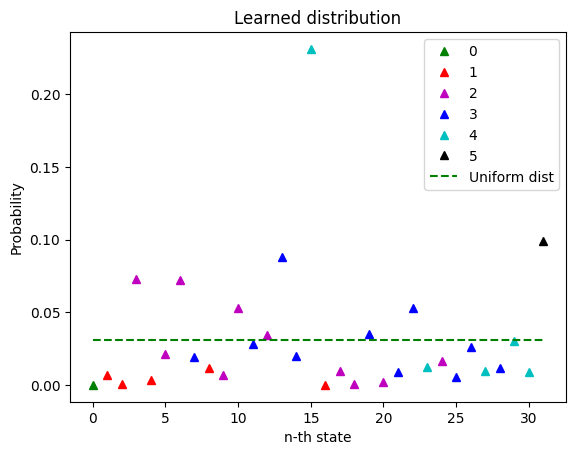

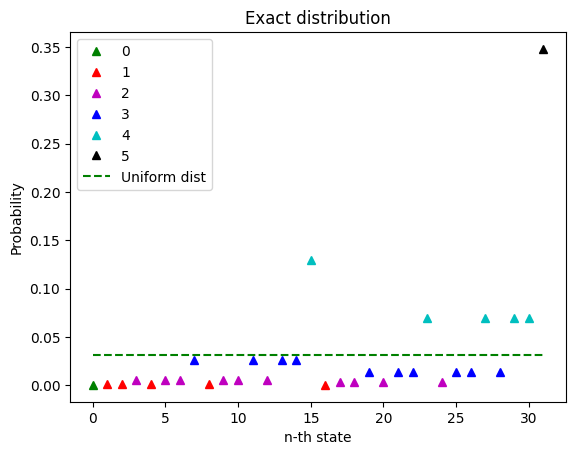

In [39]:
### Perform the same test on some other choices for W ###

# Set all biases to zero
v_bias = torch.zeros(5, dtype=torch.float) 
h_bias = torch.zeros(5, dtype=torch.float)
all_states = create_all_states(5)
n = 5

# Color code the number of 1's in a given state
colors = ["g", "r", "m", "b", "c", "k"]
sorted_states = [[], [], [], [], [], []]

# Sort states according to number of 1's
for i, state in enumerate(all_states):
    color_idx = len(state[state == 1])
    sorted_states[color_idx].append(i)

# Try different W
for i, W in enumerate(W_array):
    print(f"\nResults for W = {titles[i]}")
    print("##################################\n")
    run_test_two(W, v_bias, h_bias, verbose=False)

In [ ]:
# Load Ebo's dataset
f = "data/HG19_k6_datasets/HG19_k6_mu0.00_(20,4,5)_B0.55_N1000_00.dat"
v_data = read_input(f)
v_data[v_data == - 1] = 0
v_data.shape, v_data

In [ ]:
### Visualize the dataset ###

# Compute correlations
correlations = np.corrcoef(v_data.T)

# Plot using seaborn
sns.heatmap(correlations)

In [5]:
# Simple dataset with 5 spins
all_states = np.arange(2**5)
all_states = [np.binary_repr(x, 5) for x in all_states]
v_data_empty = np.empty(shape=(32, 5))

for i, binary_string in enumerate(all_states):
    v_data_empty[i] = np.array([int(char) for char in binary_string], dtype=np.float16)

all_states = np.array(v_data_empty, dtype=np.float16)
v_data = np.repeat(all_states, 100, axis=0)

n_visible = 5
n_hidden = 5
batch_size = 32
epochs = 5000
CD_depth = 5

v_data.shape



(3200, 5)

In [6]:
# Initialize RBM
r = RBM(num_visible = 5, num_hidden = 5)

# Train RBM
r.train(v_data, max_epochs = 5000)

Epoch 0: error is 3999.8747495820153
Epoch 1: error is 4001.082094906384
Epoch 2: error is 4003.8947888319613
Epoch 3: error is 4008.3375606841255
Epoch 4: error is 4010.0195761053055
Epoch 5: error is 4011.254735877889
Epoch 6: error is 4013.189788974849
Epoch 7: error is 4020.068480962377
Epoch 8: error is 4019.75625920968
Epoch 9: error is 4024.466837122165
Epoch 10: error is 4024.9135683522236
Epoch 11: error is 4027.7851378605537
Epoch 12: error is 4032.0935220904908
Epoch 13: error is 4031.3426902546535
Epoch 14: error is 4032.4407270327547
Epoch 15: error is 4032.4613426523015
Epoch 16: error is 4035.244506265784
Epoch 17: error is 4034.997055060763
Epoch 18: error is 4036.7763493590683
Epoch 19: error is 4038.9973569387967
Epoch 20: error is 4039.392198527701
Epoch 21: error is 4036.40779906437
Epoch 22: error is 4035.5125094917976
Epoch 23: error is 4035.1734452325113
Epoch 24: error is 4041.447116672836
Epoch 25: error is 4033.60442111681
Epoch 26: error is 4033.0381274035517

Epoch 255: error is 3866.7428134359416
Epoch 256: error is 3825.3254120798974
Epoch 257: error is 3861.0347225039964
Epoch 258: error is 3839.900102109807
Epoch 259: error is 3837.5087360159523
Epoch 260: error is 3851.752377788993
Epoch 261: error is 3844.9970083356084
Epoch 262: error is 3845.79919736473
Epoch 263: error is 3841.4846740920125
Epoch 264: error is 3854.0045981579333
Epoch 265: error is 3845.764983689868
Epoch 266: error is 3846.3079008972163
Epoch 267: error is 3806.7224252330698
Epoch 268: error is 3846.246095494702
Epoch 269: error is 3856.836227612941
Epoch 270: error is 3834.7622277886244
Epoch 271: error is 3817.9222699914253
Epoch 272: error is 3851.7224135657443
Epoch 273: error is 3818.3042993309837
Epoch 274: error is 3831.5018085570227
Epoch 275: error is 3867.483158561704
Epoch 276: error is 3862.9211150875562
Epoch 277: error is 3853.9316723875563
Epoch 278: error is 3830.6511026784738
Epoch 279: error is 3845.3617384290424
Epoch 280: error is 3822.86733730

Epoch 569: error is 3531.378397274426
Epoch 570: error is 3520.597537090737
Epoch 571: error is 3500.0785230272822
Epoch 572: error is 3529.0126986192395
Epoch 573: error is 3481.3402608529223
Epoch 574: error is 3526.2708147459634
Epoch 575: error is 3548.4749492517026
Epoch 576: error is 3505.47057064646
Epoch 577: error is 3506.38865969083
Epoch 578: error is 3543.8540323903226
Epoch 579: error is 3491.912146631976
Epoch 580: error is 3496.770785015997
Epoch 581: error is 3518.3357860253154
Epoch 582: error is 3504.598661726798
Epoch 583: error is 3528.165280074348
Epoch 584: error is 3512.2441100100154
Epoch 585: error is 3490.535206753911
Epoch 586: error is 3472.1118140051967
Epoch 587: error is 3502.953309946063
Epoch 588: error is 3494.716766003332
Epoch 589: error is 3499.4183359486283
Epoch 590: error is 3494.9330218326413
Epoch 591: error is 3499.2666703848795
Epoch 592: error is 3465.751332656847
Epoch 593: error is 3464.702214378081
Epoch 594: error is 3489.678206819283
Ep

Epoch 787: error is 2847.623325906062
Epoch 788: error is 2828.8717645644647
Epoch 789: error is 2851.5415860085404
Epoch 790: error is 2844.7064047013882
Epoch 791: error is 2859.4596719665165
Epoch 792: error is 2837.3188558927
Epoch 793: error is 2814.429893304746
Epoch 794: error is 2889.035003850081
Epoch 795: error is 2800.0302068644733
Epoch 796: error is 2842.357387283152
Epoch 797: error is 2829.131666796594
Epoch 798: error is 2796.291006196857
Epoch 799: error is 2839.0982829657596
Epoch 800: error is 2777.886811100476
Epoch 801: error is 2764.1160773866295
Epoch 802: error is 2804.039568760793
Epoch 803: error is 2803.559949558291
Epoch 804: error is 2770.0571864111844
Epoch 805: error is 2767.674829694929
Epoch 806: error is 2759.8489405158152
Epoch 807: error is 2743.9894302421994
Epoch 808: error is 2766.6943039996545
Epoch 809: error is 2736.079587628204
Epoch 810: error is 2751.7398785551695
Epoch 811: error is 2738.7599077795853
Epoch 812: error is 2746.501073359238
E

Epoch 1000: error is 2040.9863285244548
Epoch 1001: error is 2051.8833525355108
Epoch 1002: error is 2034.812560457793
Epoch 1003: error is 2030.6663333870406
Epoch 1004: error is 1991.4506943860351
Epoch 1005: error is 1974.2192660646401
Epoch 1006: error is 2029.8006008953016
Epoch 1007: error is 2031.9261625272798
Epoch 1008: error is 1964.6968608595616
Epoch 1009: error is 2003.691253011804
Epoch 1010: error is 2047.4219734454002
Epoch 1011: error is 2004.6256008214727
Epoch 1012: error is 1996.645849842837
Epoch 1013: error is 1995.3302912235545
Epoch 1014: error is 2022.1811253666206
Epoch 1015: error is 1959.6246441538678
Epoch 1016: error is 1985.1080428991436
Epoch 1017: error is 2007.0494562408467
Epoch 1018: error is 1999.1757131937393
Epoch 1019: error is 1981.31998962368
Epoch 1020: error is 1989.0629028086034
Epoch 1021: error is 2022.454741915556
Epoch 1022: error is 1947.087022203708
Epoch 1023: error is 1936.6061287247994
Epoch 1024: error is 1941.4248442646467
Epoch 1

Epoch 1211: error is 1464.0465316472246
Epoch 1212: error is 1458.3193533342471
Epoch 1213: error is 1419.044970266833
Epoch 1214: error is 1465.024906884811
Epoch 1215: error is 1464.0103517664647
Epoch 1216: error is 1454.7889722963266
Epoch 1217: error is 1491.2179576027775
Epoch 1218: error is 1472.7404982769697
Epoch 1219: error is 1470.5971566851554
Epoch 1220: error is 1415.046913521677
Epoch 1221: error is 1421.558649685584
Epoch 1222: error is 1482.6042186764037
Epoch 1223: error is 1453.8045527392621
Epoch 1224: error is 1439.4799869440458
Epoch 1225: error is 1441.6157095233089
Epoch 1226: error is 1473.851052816392
Epoch 1227: error is 1462.670760744362
Epoch 1228: error is 1406.9606068879568
Epoch 1229: error is 1443.7342808119056
Epoch 1230: error is 1453.7462290186522
Epoch 1231: error is 1434.1966366902086
Epoch 1232: error is 1440.336443673852
Epoch 1233: error is 1434.9211488042497
Epoch 1234: error is 1400.6864483227764
Epoch 1235: error is 1450.1789297117991
Epoch 1

Epoch 1534: error is 943.4998822303965
Epoch 1535: error is 946.7990260427923
Epoch 1536: error is 910.603228943334
Epoch 1537: error is 981.5243177873947
Epoch 1538: error is 958.5105270013153
Epoch 1539: error is 973.9824558824483
Epoch 1540: error is 948.3057793176407
Epoch 1541: error is 948.9028626840685
Epoch 1542: error is 905.8275633734338
Epoch 1543: error is 910.7487604227854
Epoch 1544: error is 894.5970485376324
Epoch 1545: error is 965.9680057298932
Epoch 1546: error is 888.193787150864
Epoch 1547: error is 917.1711788664676
Epoch 1548: error is 927.1757445351597
Epoch 1549: error is 923.6695360702381
Epoch 1550: error is 952.2683833185296
Epoch 1551: error is 976.2819405710932
Epoch 1552: error is 969.935270644828
Epoch 1553: error is 928.0462619819172
Epoch 1554: error is 907.45509971666
Epoch 1555: error is 921.32914282525
Epoch 1556: error is 880.9660985392767
Epoch 1557: error is 908.6704608608912
Epoch 1558: error is 905.3627099562702
Epoch 1559: error is 927.0605398

Epoch 1868: error is 674.7877018626344
Epoch 1869: error is 672.4220400597452
Epoch 1870: error is 671.6738210079952
Epoch 1871: error is 705.6665069286007
Epoch 1872: error is 692.1407392204699
Epoch 1873: error is 698.4483380732356
Epoch 1874: error is 650.9178739595524
Epoch 1875: error is 673.2837656064254
Epoch 1876: error is 657.5893637330515
Epoch 1877: error is 703.4990532916073
Epoch 1878: error is 652.5470326266126
Epoch 1879: error is 654.1556211715688
Epoch 1880: error is 672.0220081624981
Epoch 1881: error is 673.727671543483
Epoch 1882: error is 690.6741676754297
Epoch 1883: error is 665.9731690875697
Epoch 1884: error is 676.4298731626106
Epoch 1885: error is 673.5267877742938
Epoch 1886: error is 645.4395016843964
Epoch 1887: error is 656.1343797222446
Epoch 1888: error is 657.6843601542051
Epoch 1889: error is 686.4453962151281
Epoch 1890: error is 658.4825744827576
Epoch 1891: error is 675.9631558632068
Epoch 1892: error is 631.3416540511506
Epoch 1893: error is 661.1

Epoch 2151: error is 533.5108260009672
Epoch 2152: error is 553.9564270830773
Epoch 2153: error is 535.0118006770188
Epoch 2154: error is 530.4201216943815
Epoch 2155: error is 527.6135351224558
Epoch 2156: error is 540.9174380659545
Epoch 2157: error is 553.1335944885351
Epoch 2158: error is 560.0880084756755
Epoch 2159: error is 546.4461957231854
Epoch 2160: error is 547.4422009960801
Epoch 2161: error is 540.7239068217827
Epoch 2162: error is 548.5046781015526
Epoch 2163: error is 565.1383445658463
Epoch 2164: error is 553.0918423740142
Epoch 2165: error is 509.4879340928169
Epoch 2166: error is 533.6118423407851
Epoch 2167: error is 563.2209875163414
Epoch 2168: error is 551.7837078726724
Epoch 2169: error is 521.9382588020094
Epoch 2170: error is 525.7248978284225
Epoch 2171: error is 544.9724343069556
Epoch 2172: error is 535.6432709497433
Epoch 2173: error is 532.8228372256624
Epoch 2174: error is 507.29570614033025
Epoch 2175: error is 502.91033342768594
Epoch 2176: error is 51

Epoch 2466: error is 441.2772383759486
Epoch 2467: error is 440.9788788892417
Epoch 2468: error is 462.4926183478832
Epoch 2469: error is 406.3630989260938
Epoch 2470: error is 449.7748892865935
Epoch 2471: error is 440.5104091438861
Epoch 2472: error is 454.7706562744617
Epoch 2473: error is 446.9395959691675
Epoch 2474: error is 440.37690893589945
Epoch 2475: error is 389.70472050743007
Epoch 2476: error is 450.3888097600429
Epoch 2477: error is 496.18126608204784
Epoch 2478: error is 445.2690131321912
Epoch 2479: error is 420.8659387773057
Epoch 2480: error is 463.64402170864753
Epoch 2481: error is 447.03127678616846
Epoch 2482: error is 426.8434091026602
Epoch 2483: error is 431.63296133805636
Epoch 2484: error is 443.3015064869519
Epoch 2485: error is 413.2172003546243
Epoch 2486: error is 447.8648010403392
Epoch 2487: error is 426.5331051433501
Epoch 2488: error is 451.5926728467905
Epoch 2489: error is 461.0741206235986
Epoch 2490: error is 457.59792642604725
Epoch 2491: error 

Epoch 2815: error is 411.1705897955359
Epoch 2816: error is 390.24526828415145
Epoch 2817: error is 348.7050652597963
Epoch 2818: error is 353.8212937695767
Epoch 2819: error is 366.7823822475934
Epoch 2820: error is 339.2714686469508
Epoch 2821: error is 360.24554355783243
Epoch 2822: error is 366.54427488596156
Epoch 2823: error is 362.8048684959813
Epoch 2824: error is 354.6097354455776
Epoch 2825: error is 350.57369323566763
Epoch 2826: error is 384.23609033772885
Epoch 2827: error is 371.5126356065091
Epoch 2828: error is 383.77983694498187
Epoch 2829: error is 380.9636202053785
Epoch 2830: error is 345.6513262272619
Epoch 2831: error is 367.09773939554816
Epoch 2832: error is 375.38581287018667
Epoch 2833: error is 347.86752397728026
Epoch 2834: error is 382.7740694794769
Epoch 2835: error is 382.45041473151
Epoch 2836: error is 385.5309412008256
Epoch 2837: error is 372.6164090051245
Epoch 2838: error is 384.016317309618
Epoch 2839: error is 364.7488033283045
Epoch 2840: error i

Epoch 3137: error is 329.0571951584875
Epoch 3138: error is 331.6176389832184
Epoch 3139: error is 337.52905454868636
Epoch 3140: error is 281.4758790456596
Epoch 3141: error is 307.57999315185475
Epoch 3142: error is 299.0943523006208
Epoch 3143: error is 333.3782962657559
Epoch 3144: error is 310.13002606119977
Epoch 3145: error is 315.1621634204311
Epoch 3146: error is 322.45925986031244
Epoch 3147: error is 331.38625512377547
Epoch 3148: error is 317.57050991406396
Epoch 3149: error is 314.546361864654
Epoch 3150: error is 315.0135761812359
Epoch 3151: error is 344.4160532654975
Epoch 3152: error is 293.87244491062694
Epoch 3153: error is 338.1695421781903
Epoch 3154: error is 346.2820740308041
Epoch 3155: error is 334.1486464655652
Epoch 3156: error is 343.91792245802526
Epoch 3157: error is 320.76571523844177
Epoch 3158: error is 325.37491984087563
Epoch 3159: error is 303.50976144754276
Epoch 3160: error is 326.25015155114124
Epoch 3161: error is 299.73683374776664
Epoch 3162: e

Epoch 3409: error is 312.76106194997993
Epoch 3410: error is 281.6015133900314
Epoch 3411: error is 279.83273456633526
Epoch 3412: error is 280.31960179511236
Epoch 3413: error is 277.4887326137465
Epoch 3414: error is 310.9312635660925
Epoch 3415: error is 297.0868691058667
Epoch 3416: error is 303.0411480081475
Epoch 3417: error is 315.41363633799347
Epoch 3418: error is 294.9794410707899
Epoch 3419: error is 299.3654569360361
Epoch 3420: error is 296.57382770501476
Epoch 3421: error is 287.0895787014098
Epoch 3422: error is 280.73163751624804
Epoch 3423: error is 293.44864650275235
Epoch 3424: error is 314.05041107255647
Epoch 3425: error is 273.49142024443995
Epoch 3426: error is 264.1773986184209
Epoch 3427: error is 265.0744260138999
Epoch 3428: error is 261.99235107177066
Epoch 3429: error is 276.30650700236794
Epoch 3430: error is 328.86960677392887
Epoch 3431: error is 279.6086479133008
Epoch 3432: error is 304.14175726530993
Epoch 3433: error is 294.0987164599849
Epoch 3434: 

Epoch 3711: error is 242.70051521373568
Epoch 3712: error is 291.33379565035534
Epoch 3713: error is 258.8629453818728
Epoch 3714: error is 261.8683352979705
Epoch 3715: error is 263.519027524981
Epoch 3716: error is 278.5523444299827
Epoch 3717: error is 281.2418359098707
Epoch 3718: error is 259.1428222057693
Epoch 3719: error is 279.22974446938053
Epoch 3720: error is 245.23351690873568
Epoch 3721: error is 253.61601991534073
Epoch 3722: error is 242.60982854997116
Epoch 3723: error is 244.3629155721282
Epoch 3724: error is 258.54132889373665
Epoch 3725: error is 254.92295050707327
Epoch 3726: error is 253.44373367919238
Epoch 3727: error is 240.48522407587677
Epoch 3728: error is 267.5252060227678
Epoch 3729: error is 275.058077097017
Epoch 3730: error is 285.4096921698161
Epoch 3731: error is 271.6990423998121
Epoch 3732: error is 233.35620438935229
Epoch 3733: error is 265.1324347746468
Epoch 3734: error is 246.91489105948057
Epoch 3735: error is 257.4077564912616
Epoch 3736: err

Epoch 4026: error is 236.51807953828504
Epoch 4027: error is 242.13753811840382
Epoch 4028: error is 255.98184446810245
Epoch 4029: error is 242.82726808109265
Epoch 4030: error is 243.0205247378673
Epoch 4031: error is 271.7833263803142
Epoch 4032: error is 229.09215261642464
Epoch 4033: error is 229.69821567550312
Epoch 4034: error is 232.4010877318444
Epoch 4035: error is 247.96525642979142
Epoch 4036: error is 235.29912746960434
Epoch 4037: error is 215.8155842040184
Epoch 4038: error is 242.74783059393963
Epoch 4039: error is 221.1360539196518
Epoch 4040: error is 248.06470993114073
Epoch 4041: error is 239.39254805839278
Epoch 4042: error is 239.34165148845037
Epoch 4043: error is 218.84548130621823
Epoch 4044: error is 230.36614751558818
Epoch 4045: error is 224.48868245592018
Epoch 4046: error is 253.5738496953664
Epoch 4047: error is 238.0696806525776
Epoch 4048: error is 212.42959835713555
Epoch 4049: error is 254.13085253618408
Epoch 4050: error is 254.01024432615867
Epoch 4

Epoch 4291: error is 197.1571128200061
Epoch 4292: error is 228.51866895454611
Epoch 4293: error is 207.74360706776065
Epoch 4294: error is 214.62006364645873
Epoch 4295: error is 231.31591747882032
Epoch 4296: error is 210.75117833657555
Epoch 4297: error is 237.12783496398492
Epoch 4298: error is 216.43499187878552
Epoch 4299: error is 239.3974432232685
Epoch 4300: error is 238.23817222393296
Epoch 4301: error is 218.57066898596202
Epoch 4302: error is 227.5959024359346
Epoch 4303: error is 203.0117984089209
Epoch 4304: error is 237.31402687253996
Epoch 4305: error is 222.5827282950914
Epoch 4306: error is 202.86726400903478
Epoch 4307: error is 197.31596964001417
Epoch 4308: error is 198.24546567686775
Epoch 4309: error is 201.52170361190963
Epoch 4310: error is 230.26707504454114
Epoch 4311: error is 211.83788899632464
Epoch 4312: error is 210.10125072450796
Epoch 4313: error is 241.67399587988155
Epoch 4314: error is 205.8116151288233
Epoch 4315: error is 225.78034056529367
Epoch 

Epoch 4605: error is 225.10753964465593
Epoch 4606: error is 197.31848363266468
Epoch 4607: error is 215.60565678013984
Epoch 4608: error is 210.4679662860915
Epoch 4609: error is 189.45518617822296
Epoch 4610: error is 187.3728441109696
Epoch 4611: error is 217.77369229104443
Epoch 4612: error is 224.47497453382243
Epoch 4613: error is 205.1771836018021
Epoch 4614: error is 183.60922814446064
Epoch 4615: error is 192.3157822847437
Epoch 4616: error is 210.8709328380982
Epoch 4617: error is 205.90625435690026
Epoch 4618: error is 208.8540777843096
Epoch 4619: error is 205.8226823733905
Epoch 4620: error is 208.70791234764147
Epoch 4621: error is 221.43265697739218
Epoch 4622: error is 207.86139130550566
Epoch 4623: error is 193.19812699284668
Epoch 4624: error is 208.72474134771875
Epoch 4625: error is 222.58716368701246
Epoch 4626: error is 232.7408301599912
Epoch 4627: error is 216.68771656854818
Epoch 4628: error is 210.74713625782874
Epoch 4629: error is 196.98885867851084
Epoch 46

Epoch 4874: error is 204.8863179420279
Epoch 4875: error is 192.00684098610685
Epoch 4876: error is 161.811736504102
Epoch 4877: error is 210.71727858345736
Epoch 4878: error is 206.30472132987163
Epoch 4879: error is 218.57586453206076
Epoch 4880: error is 178.40574797783
Epoch 4881: error is 207.14145711986507
Epoch 4882: error is 185.2586169529924
Epoch 4883: error is 177.24125695569342
Epoch 4884: error is 208.46370698198098
Epoch 4885: error is 203.19609076583123
Epoch 4886: error is 215.55225733356366
Epoch 4887: error is 182.38414047982323
Epoch 4888: error is 184.23098994663005
Epoch 4889: error is 196.98587160226344
Epoch 4890: error is 198.19614122708575
Epoch 4891: error is 177.691262664402
Epoch 4892: error is 221.60297636827235
Epoch 4893: error is 199.97021226647053
Epoch 4894: error is 165.02794191059476
Epoch 4895: error is 197.83550369863286
Epoch 4896: error is 202.93937908187985
Epoch 4897: error is 187.5290267233574
Epoch 4898: error is 191.05040074438313
Epoch 4899

In [143]:
# user = np.zeros(20)
# user[15:] = 1
# print(user)
# print(r.run_visible(np.array([user])))

W = r.weights[1:, 1:]
v_bias = r.weights[:, 0][1:]
h_bias = r.weights[0][1:]

W.shape, v_bias.shape, h_bias.shape

((5, 5), (5,), (5,))

[ 0.          5.06897763  5.03868926 10.10766689  5.0737516  10.14272923
 10.11244085 15.18141848  5.04388278 10.11286042 10.08257204 15.15154967
 10.11763438 15.18661201 15.15632364 20.22530127  5.00265994 10.07163757
 10.04134919 15.11032682 10.07641153 15.14538917 15.11510079 20.18407842
 10.04654272 15.11552035 15.08523198 20.15420961 15.12029432 20.18927195
 20.15898357 25.2279612 ]


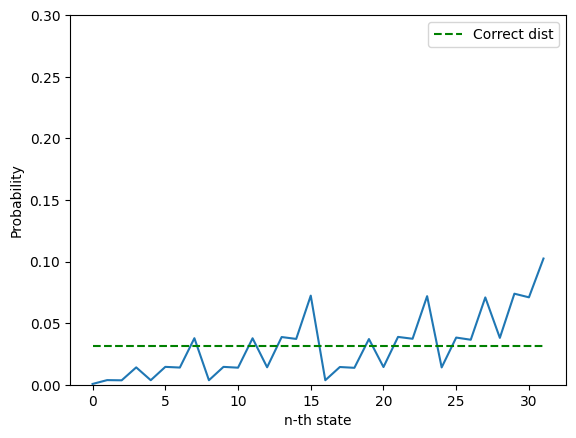

In [150]:
# Compute energy
# Compute energy
def energy(v, h, W, v_bias, h_bias):
    # NOTE: The weight array has as index W_vh. 
    W = -(v @ W @ h.T)
    print(v @ v_bias)
    return  W - np.repeat((v @ v_bias).reshape(32, 1), 32, axis=1).T - (h @ h_bias)

def compute_model_statistics(weights, v_bias, h_bias):
    # Compute energy for each state
    energy_all_states = np.exp(energy(all_states, all_states, W, v_bias, h_bias))

    # Compute partition function
    Z = np.sum(energy_all_states)

    # Compute model distributions
    v_prob_model = np.sum(energy_all_states, axis=1) / Z
    vh_prob_model = energy_all_states / Z

    return vh_prob_model, v_prob_model

vh_prob_model, v_prob_model = compute_model_statistics(r.weights[:-1, :-1], v_bias, h_bias)

# Plot P(v)_model
plt.plot(np.arange(32), v_prob_model)
plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Correct dist")
plt.ylim(0, 0.3)
plt.xlabel("n-th state")
plt.ylabel("Probability")
plt.legend()
plt.show()


In [118]:
np.repeat(v_prob_model.reshape(32, 1), 100, axis=1).shape, v_data.shape

((32, 100), (3200, 5))

In [125]:
k = 10
for _ in range(k):
    h_probs = r.run_hidden(v_data)
    v_probs_recon = r.run_visible(h_probs)

np.sum((v_prob_model - (1/32)) ** 2), np.sum((v_probs_recon - v_data) ** 2)

(0.5474370835122109, 423.0)

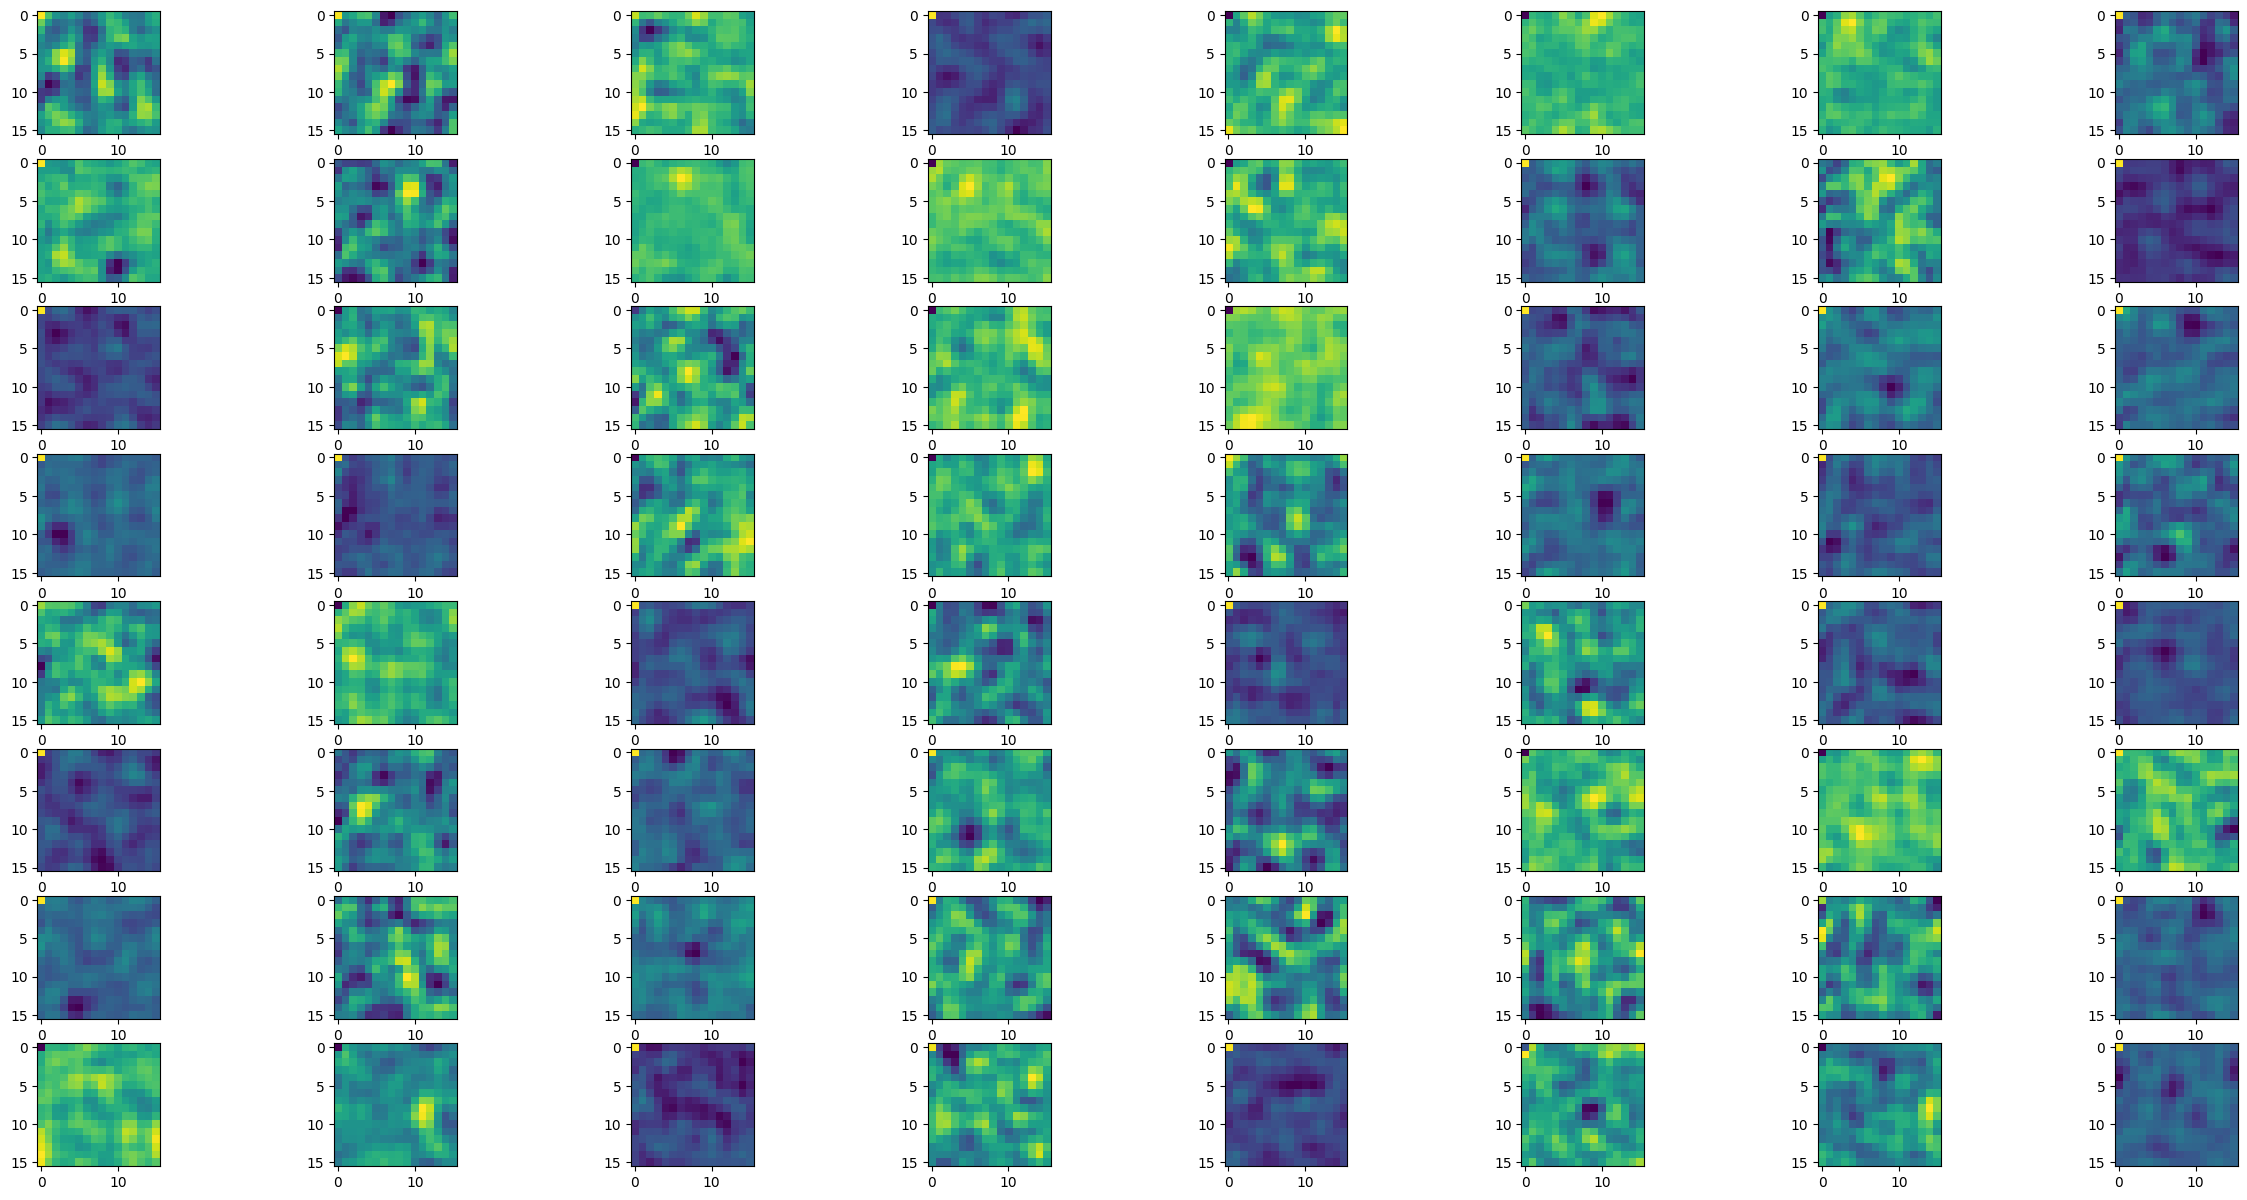

In [54]:
fig, ax = plt.subplots(8, 8, figsize=(30, 15))


for i, receptive_field in enumerate(r.weights.T):
    receptive_field = receptive_field[:-1].reshape(16, 16)

    row = (i // 8) - 1
    col = i % 8
    ax[row, col].imshow(receptive_field)

    # ax[i].set_xlabel("n-th visible spin")
    # ax[i].set_ylabel("weight")

plt.show()